# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [7]:
# %pip install -e "C:\Users\charl\Documents\Python dev\DiadFit"

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.81'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [9]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'
# What is your file extension? .txt, .csv, .xlsx?
file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
prefix_str=' '

# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower)


Filetype headless_txt is valid.


In [10]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['01 Ne--Spectrum--000--Spec.Data 1.txt',
 '02 Ne--Spectrum--001--Spec.Data 1.txt',
 '03 Ne--Spectrum--002--Spec.Data 1.txt',
 '08 Ne--Spectrum--015--Spec.Data 1.txt',
 '11 Ne--Spectrum--020--Spec.Data 1.txt',
 '15 Ne--Spectrum--026--Spec.Data 1.txt',
 '20 Ne--Spectrum--032--Spec.Data 1.txt',
 '22 Ne--Spectrum--043--Spec.Data 1.txt',
 '25 Ne--Spectrum--048--Spec.Data 1.txt',
 '35 Ne--Spectrum--060--Spec.Data 1.txt',
 '39 Ne--Spectrum--073--Spec.Data 1.txt',
 '43 Ne--Spectrum--079--Spec.Data 1.txt',
 '47 Ne--Spectrum--090--Spec.Data 1.txt',
 '51 Ne--Spectrum--096--Spec.Data 1.txt',
 '59 Ne--Spectrum--106--Spec.Data 1.txt',
 '73 Ne--Spectrum--130--Spec.Data 1.txt',
 '77 Ne--Spectrum--137--Spec.Data 1.txt',
 '84 Ne--Spectrum--157--Spec.Data 1.txt',
 '89 Ne--Spectrum--166--Spec.Data 1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [11]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
3           391.536362     2500.0                543.36513
15          818.699523     5000.0                556.27662
18          818.699523     5000.0                556.27662
26         1117.086987     5000.0                565.66588
33         1310.480205     5000.0                571.92248

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [12]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  330.477634  1117.086987  1447.564622                1117   

   Entered Pos Line 2  
0                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [13]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne--Spectrum--000--Spec.Data 1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.16583   4924.666504  1447.138537   46808.66797  4210.799835   

     Peak2_prom  
0  46094.801301

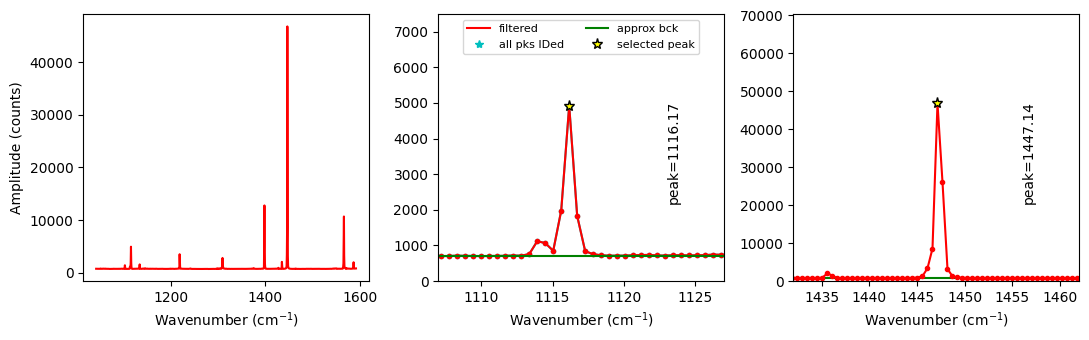

In [14]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [15]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [16]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  \
0  Ne--Spectrum--000--Spec.Data 1.txt         0.000039    0.000039   

   pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  \
0    1447.280451   47093.368755   0.378465      None    0.00321   

   Peak2_Prop_Lor  pk1_peak_cent  ...  pk1_gamma  error_pk1 Peak1_Prop_Lor  \
0        0.376862    1116.150616  ...       None   0.012448       0.286513   

      deltaNe  Ne_Corr  Ne_Corr_min  Ne_Corr_max  residual_pk2  residual_pk1  \
0  331.129836  0.99803     0.997983     0.998078    111.151104      9.291593   

   residual_pk1+pk2  
0        120.442697  

[1 rows x 22 columns]

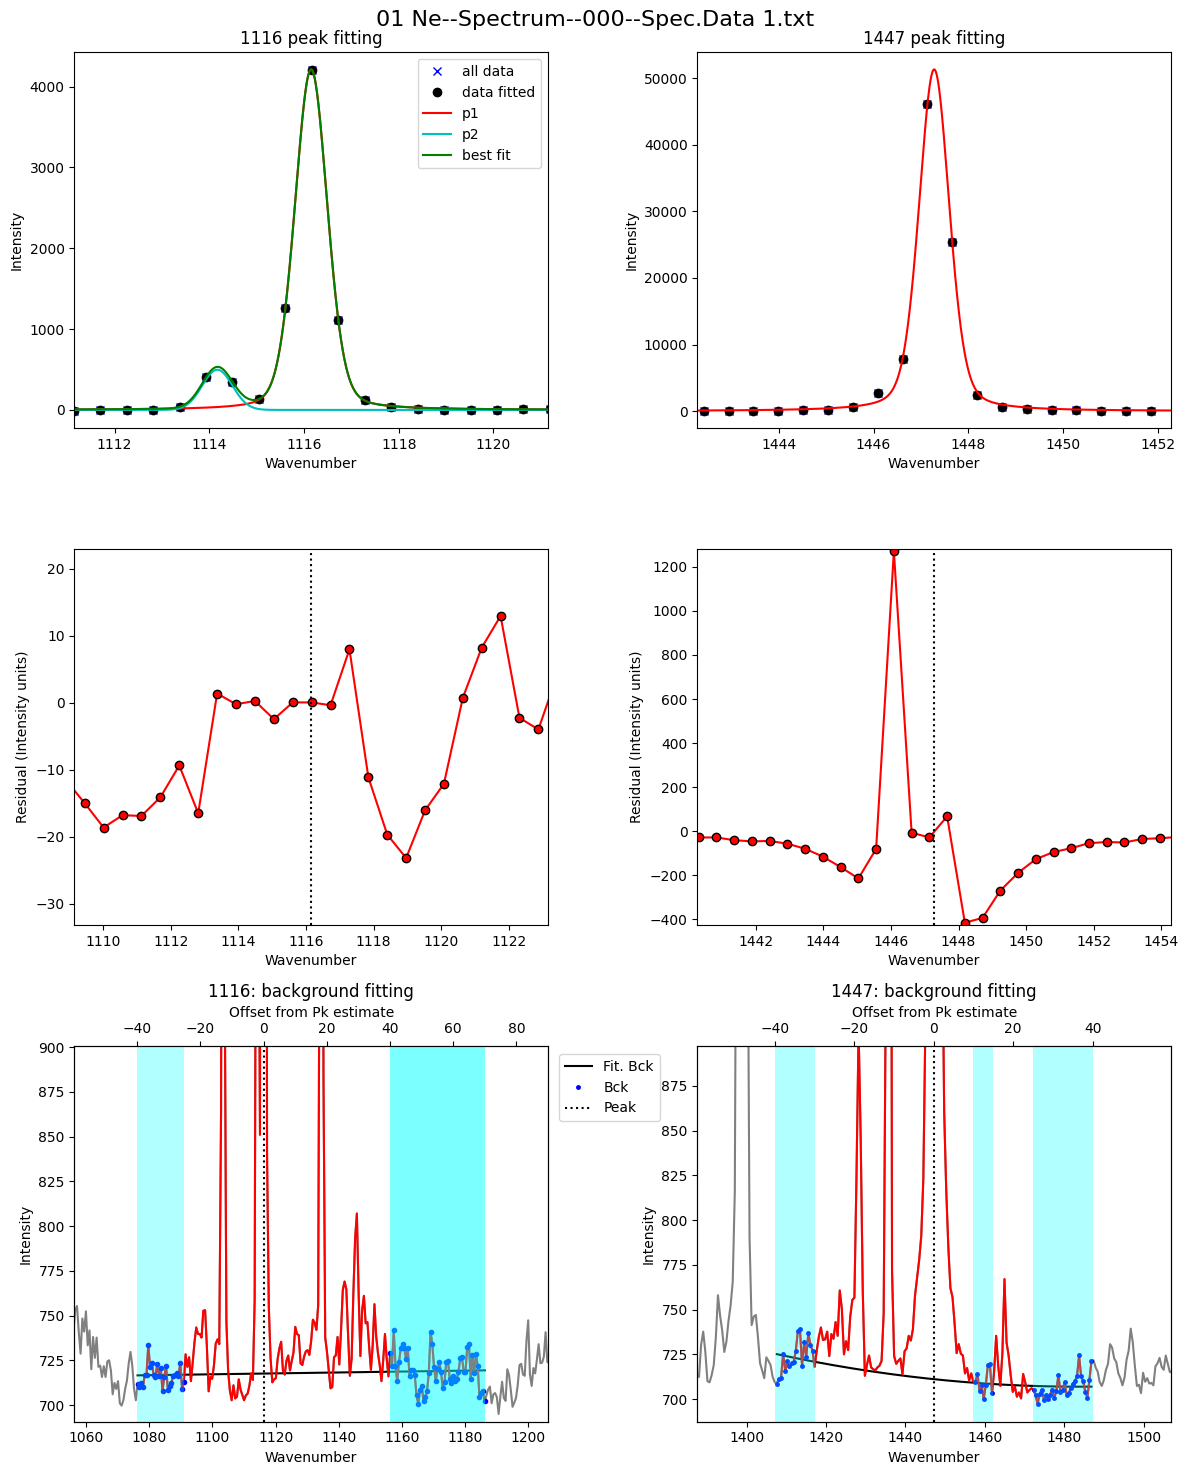

In [17]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [18]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/19 [00:00<?, ?it/s]

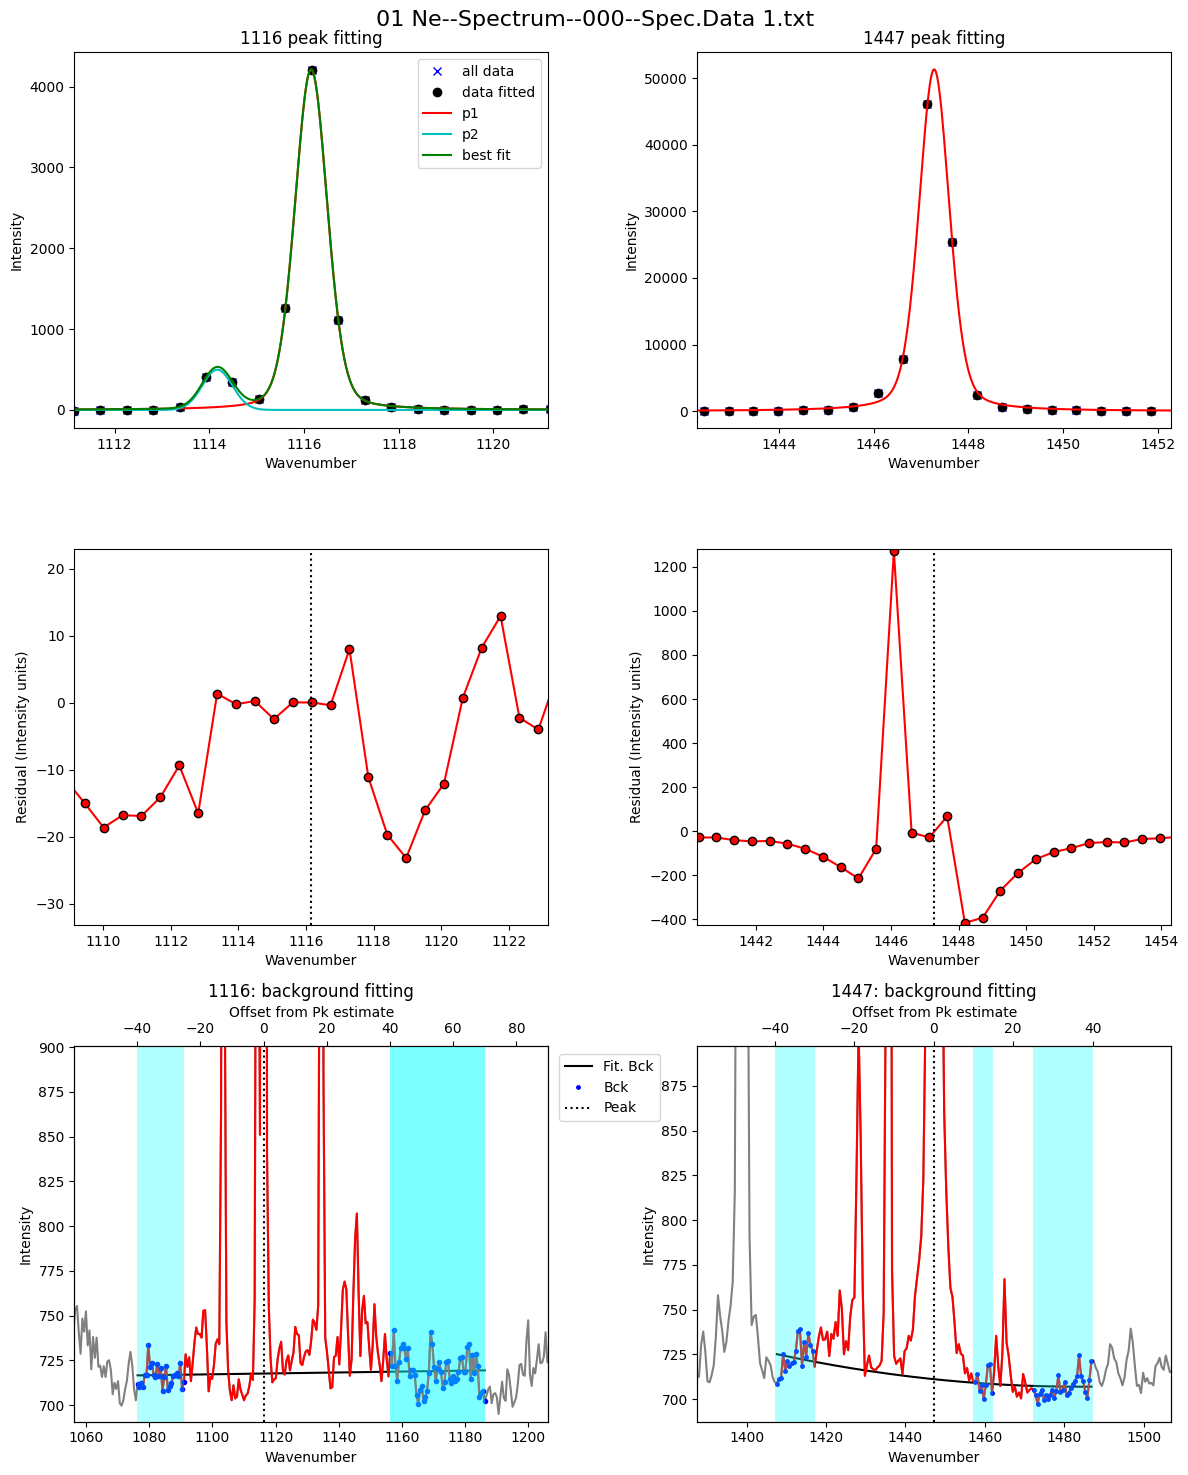

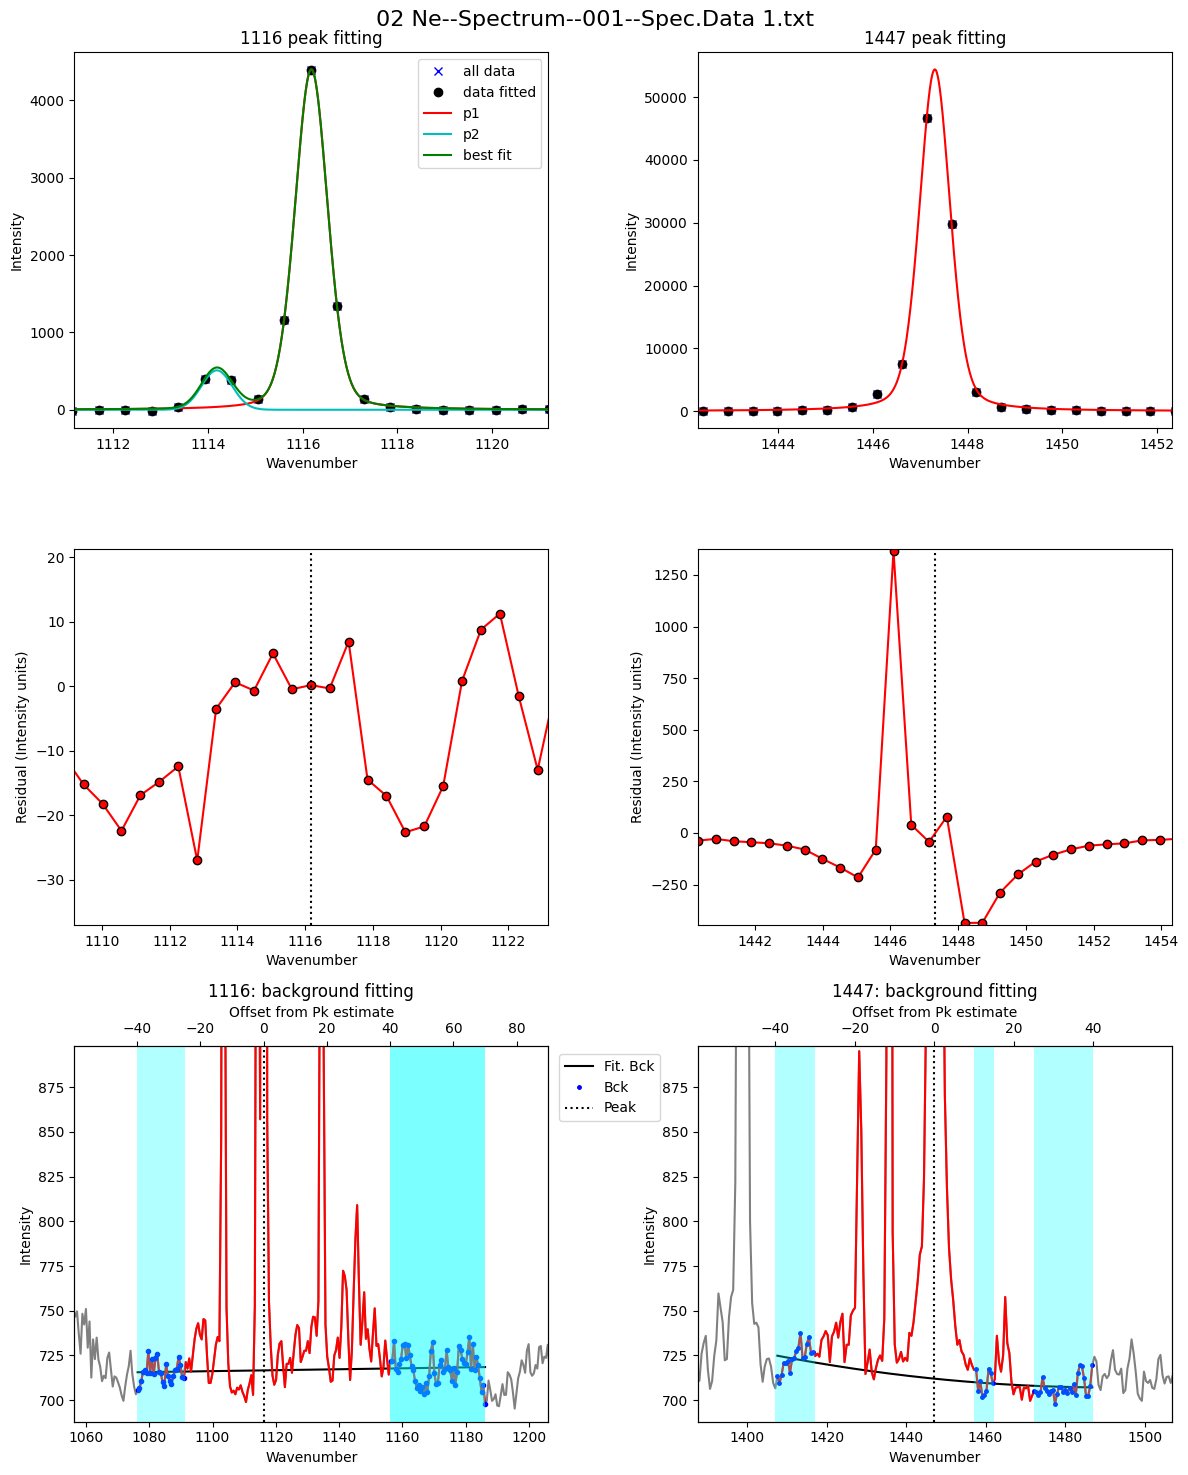

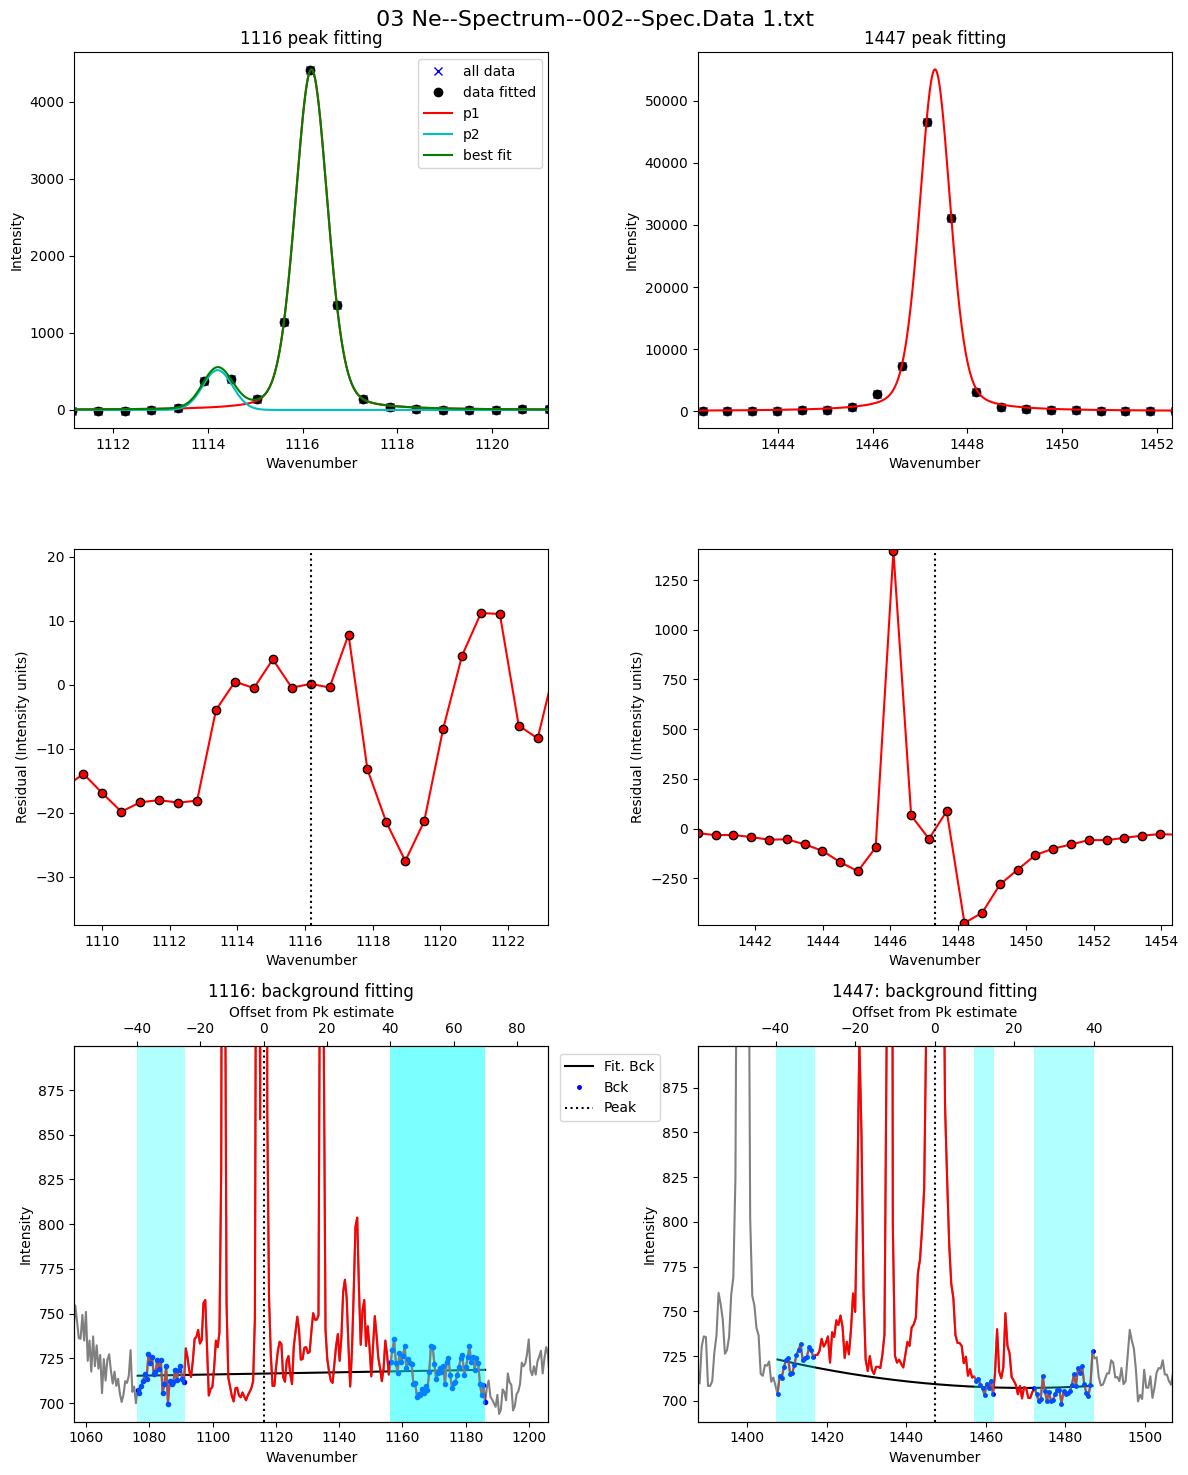

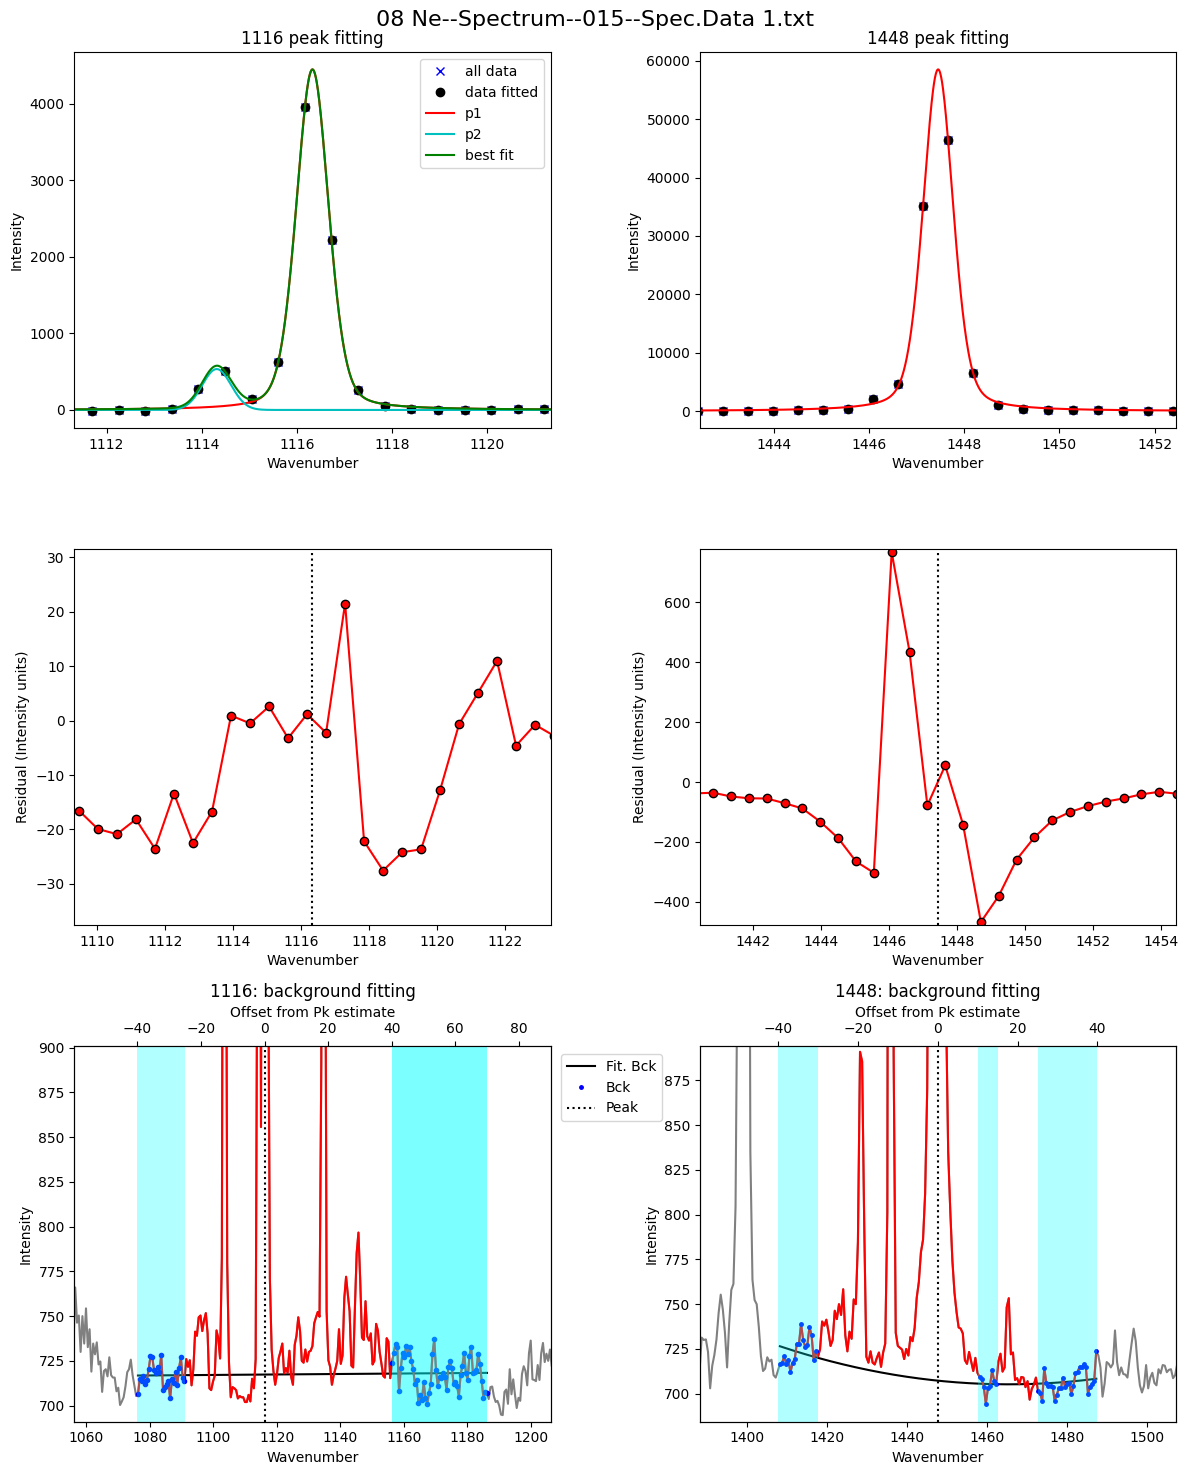

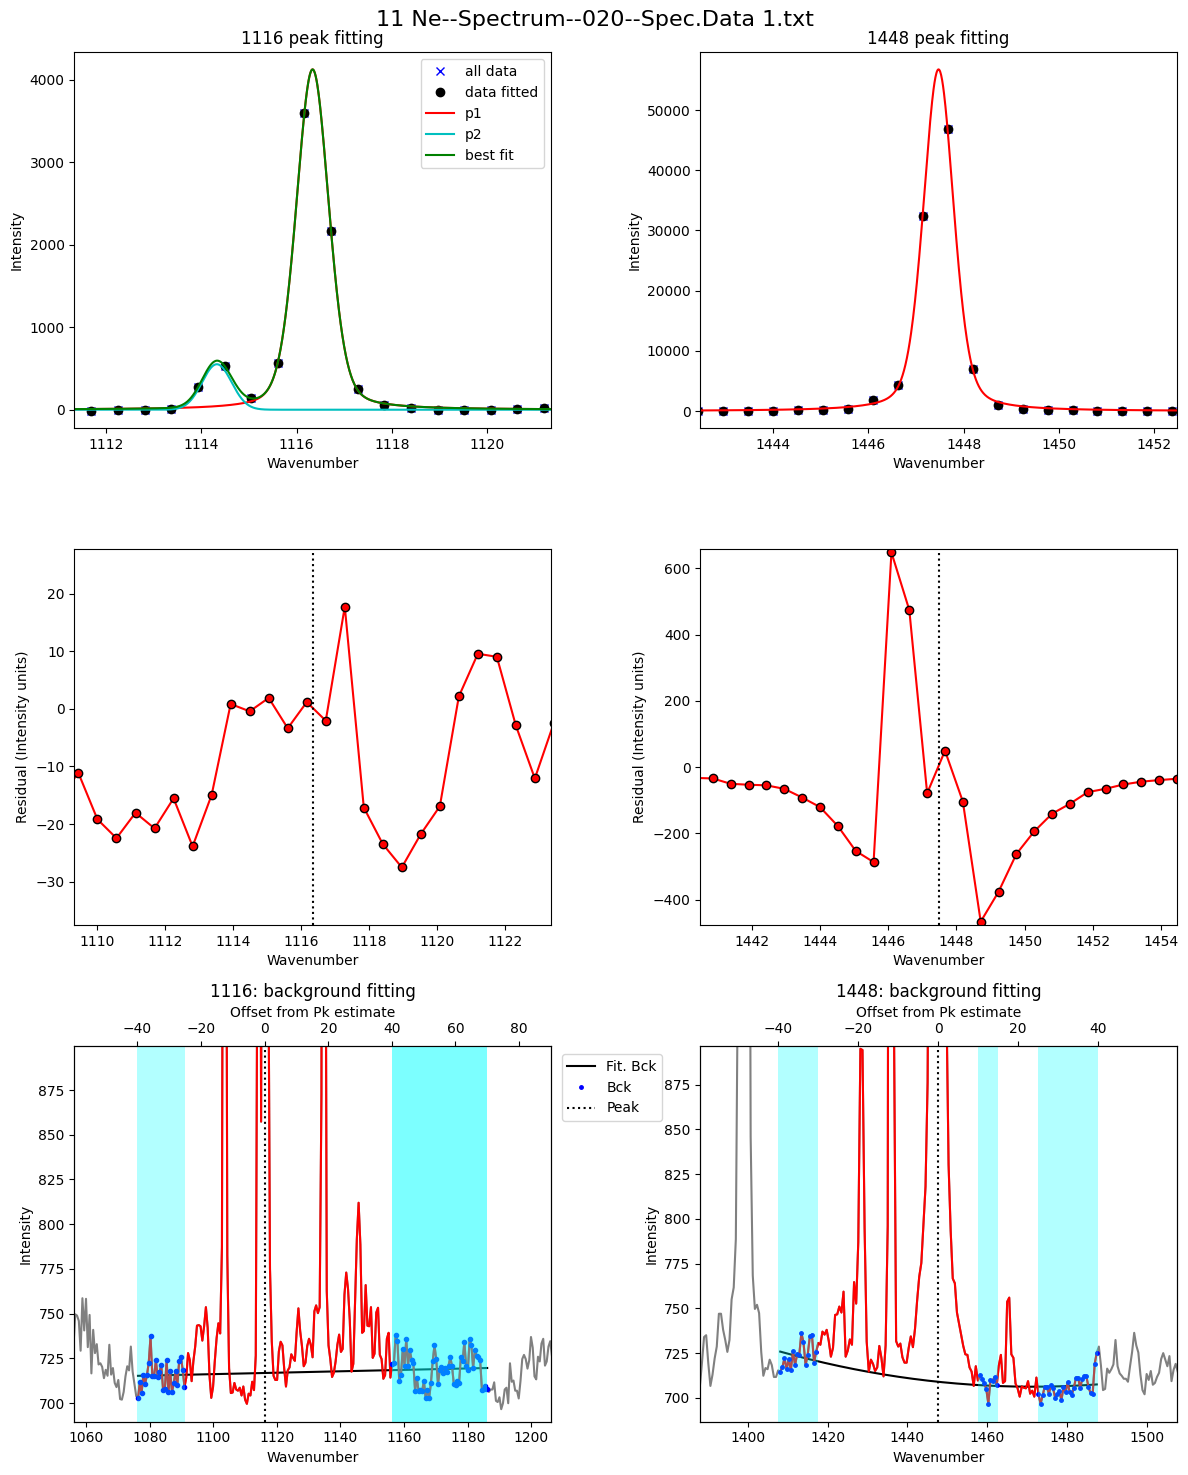

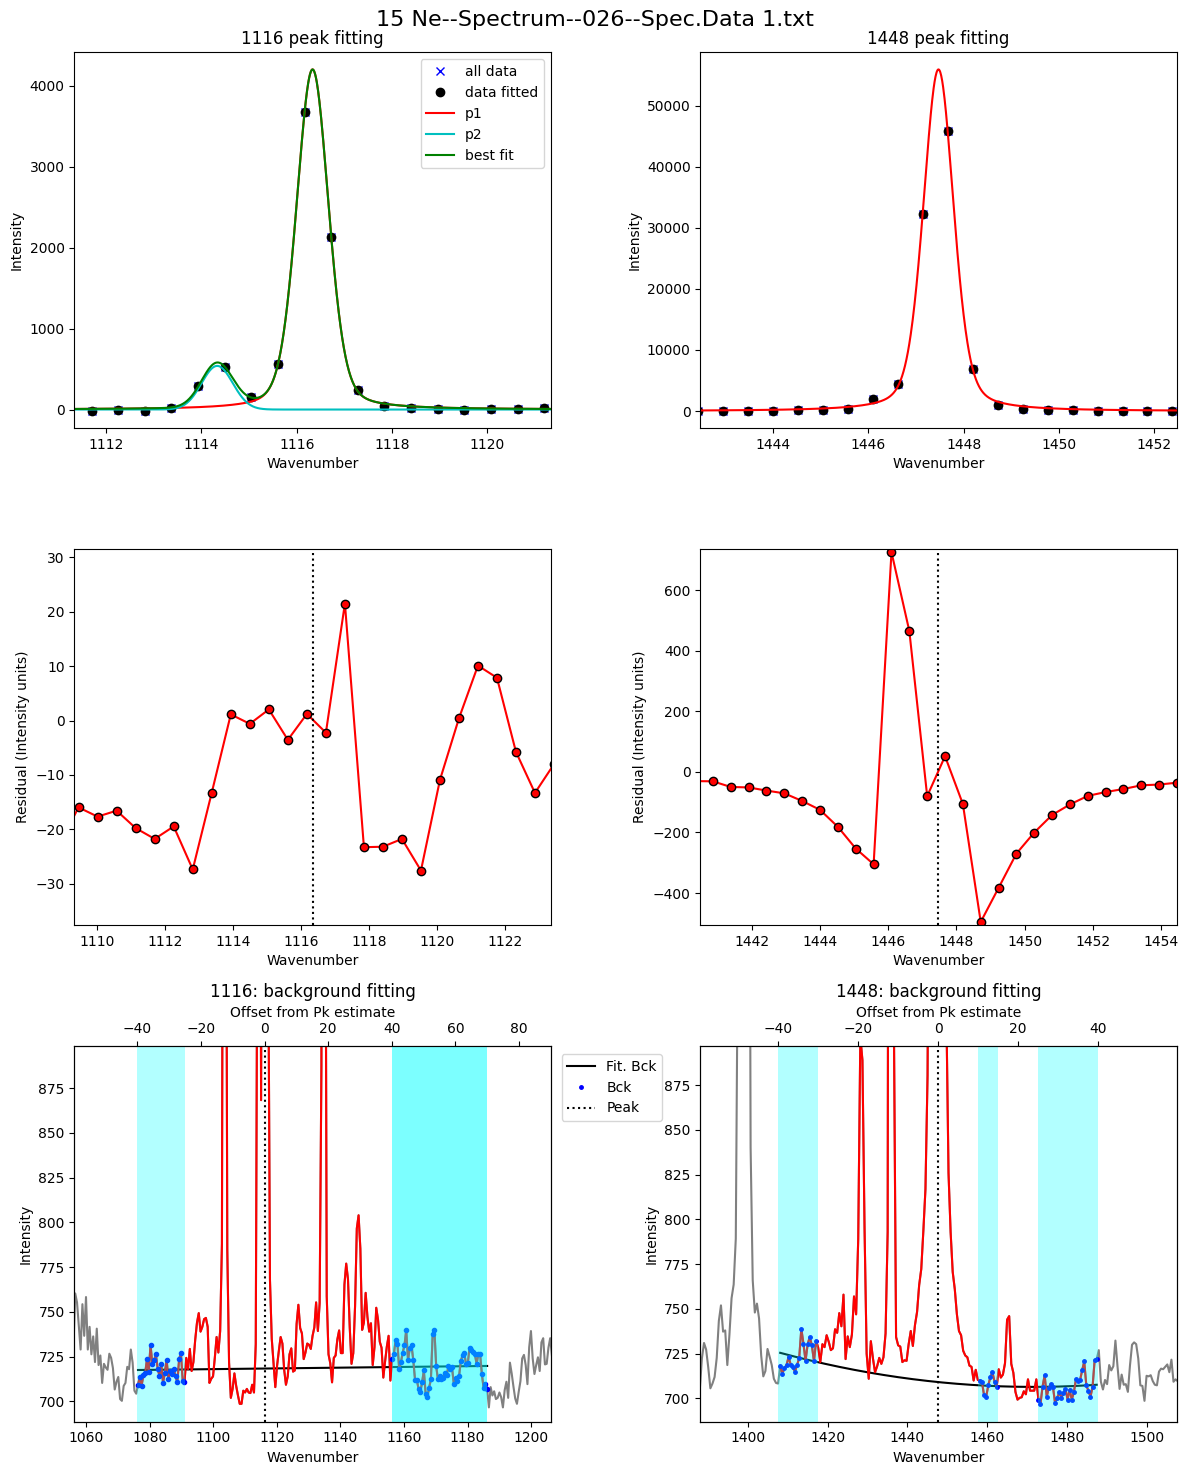

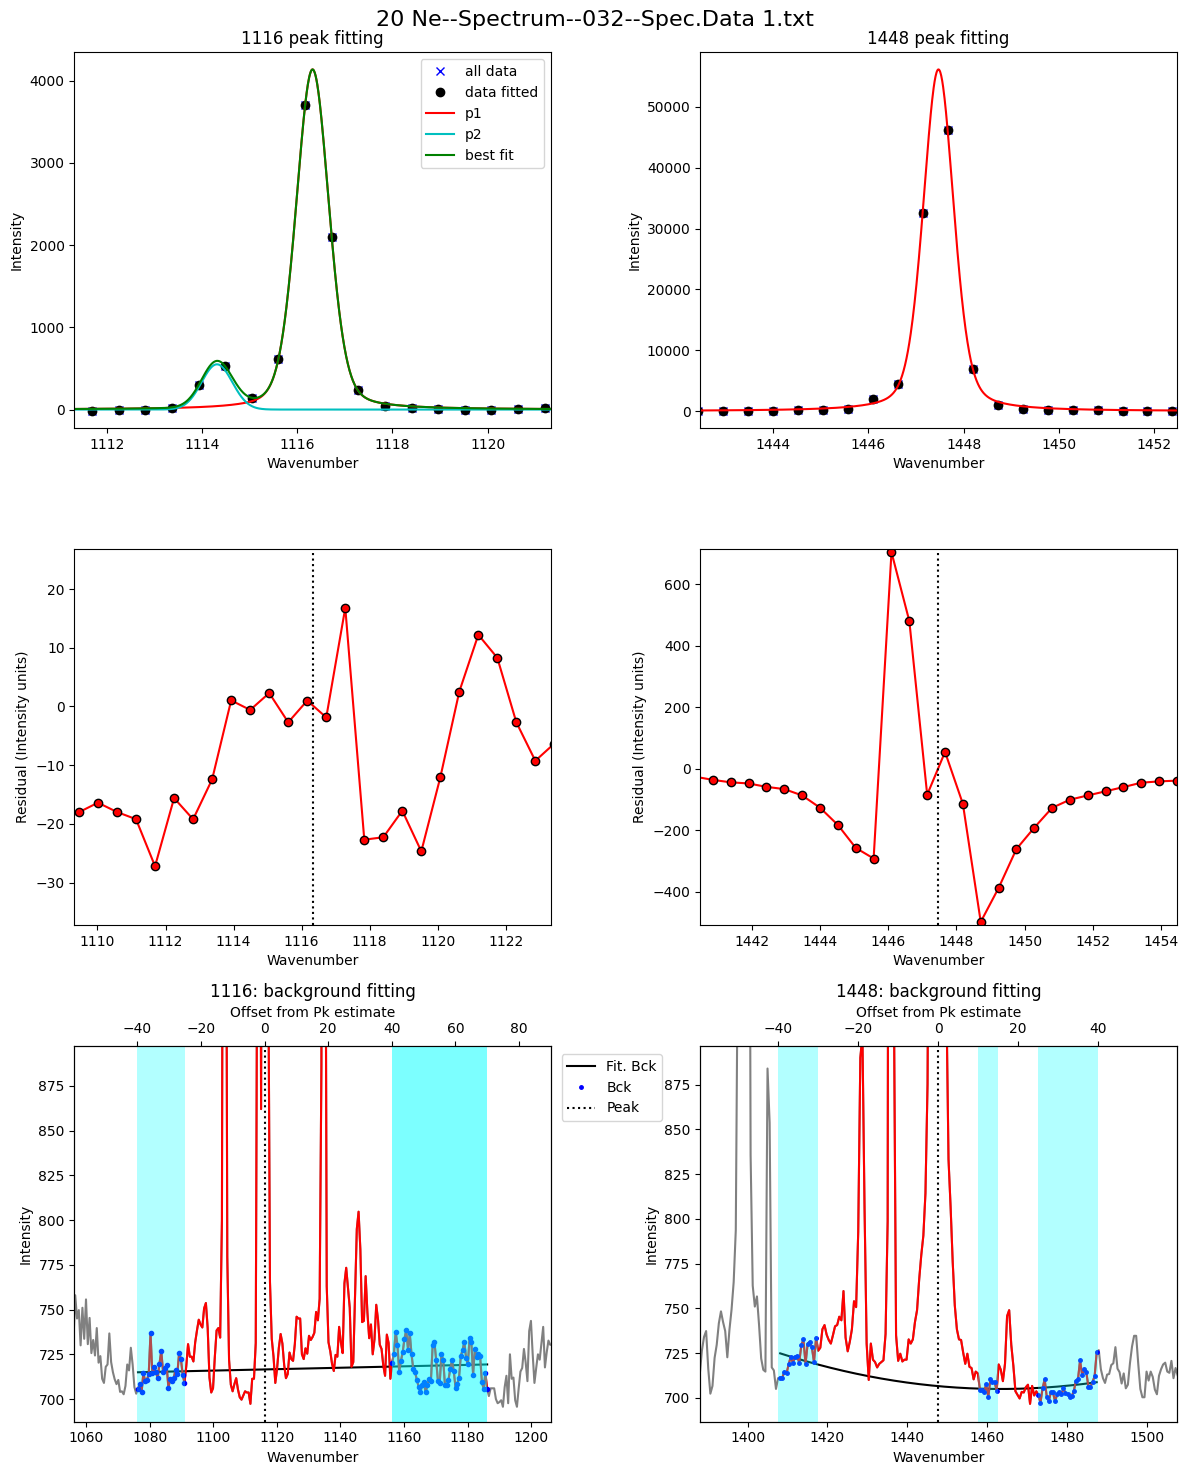

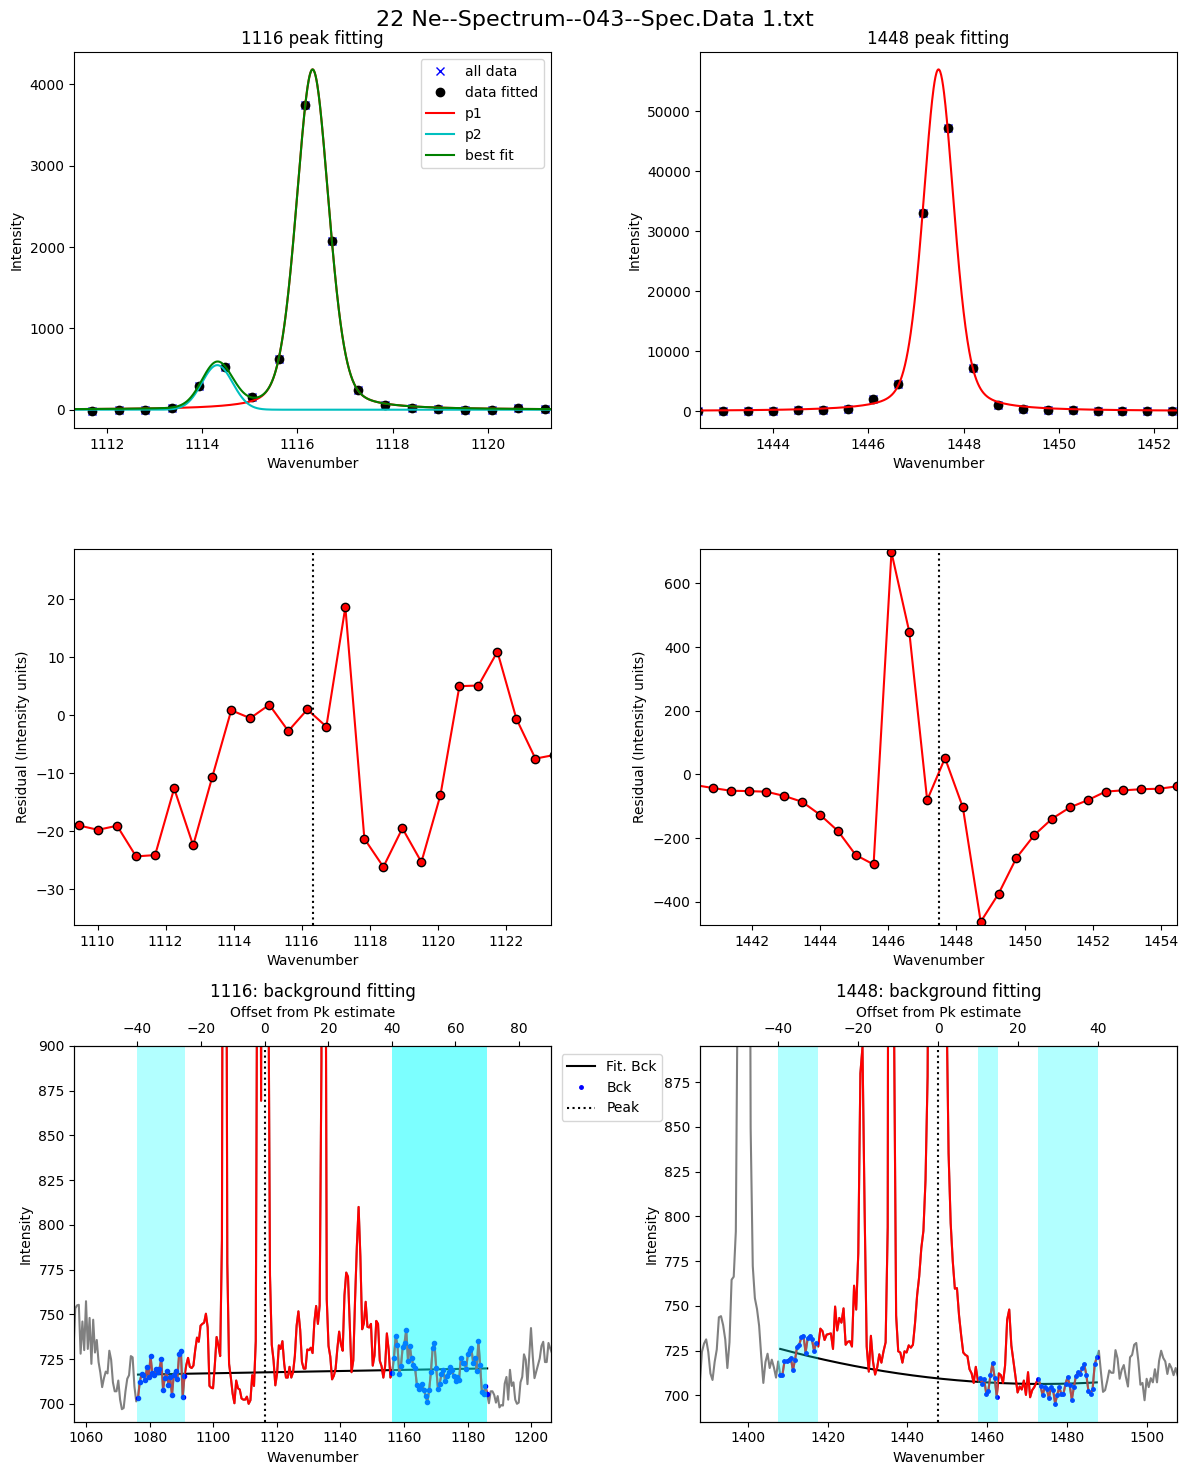

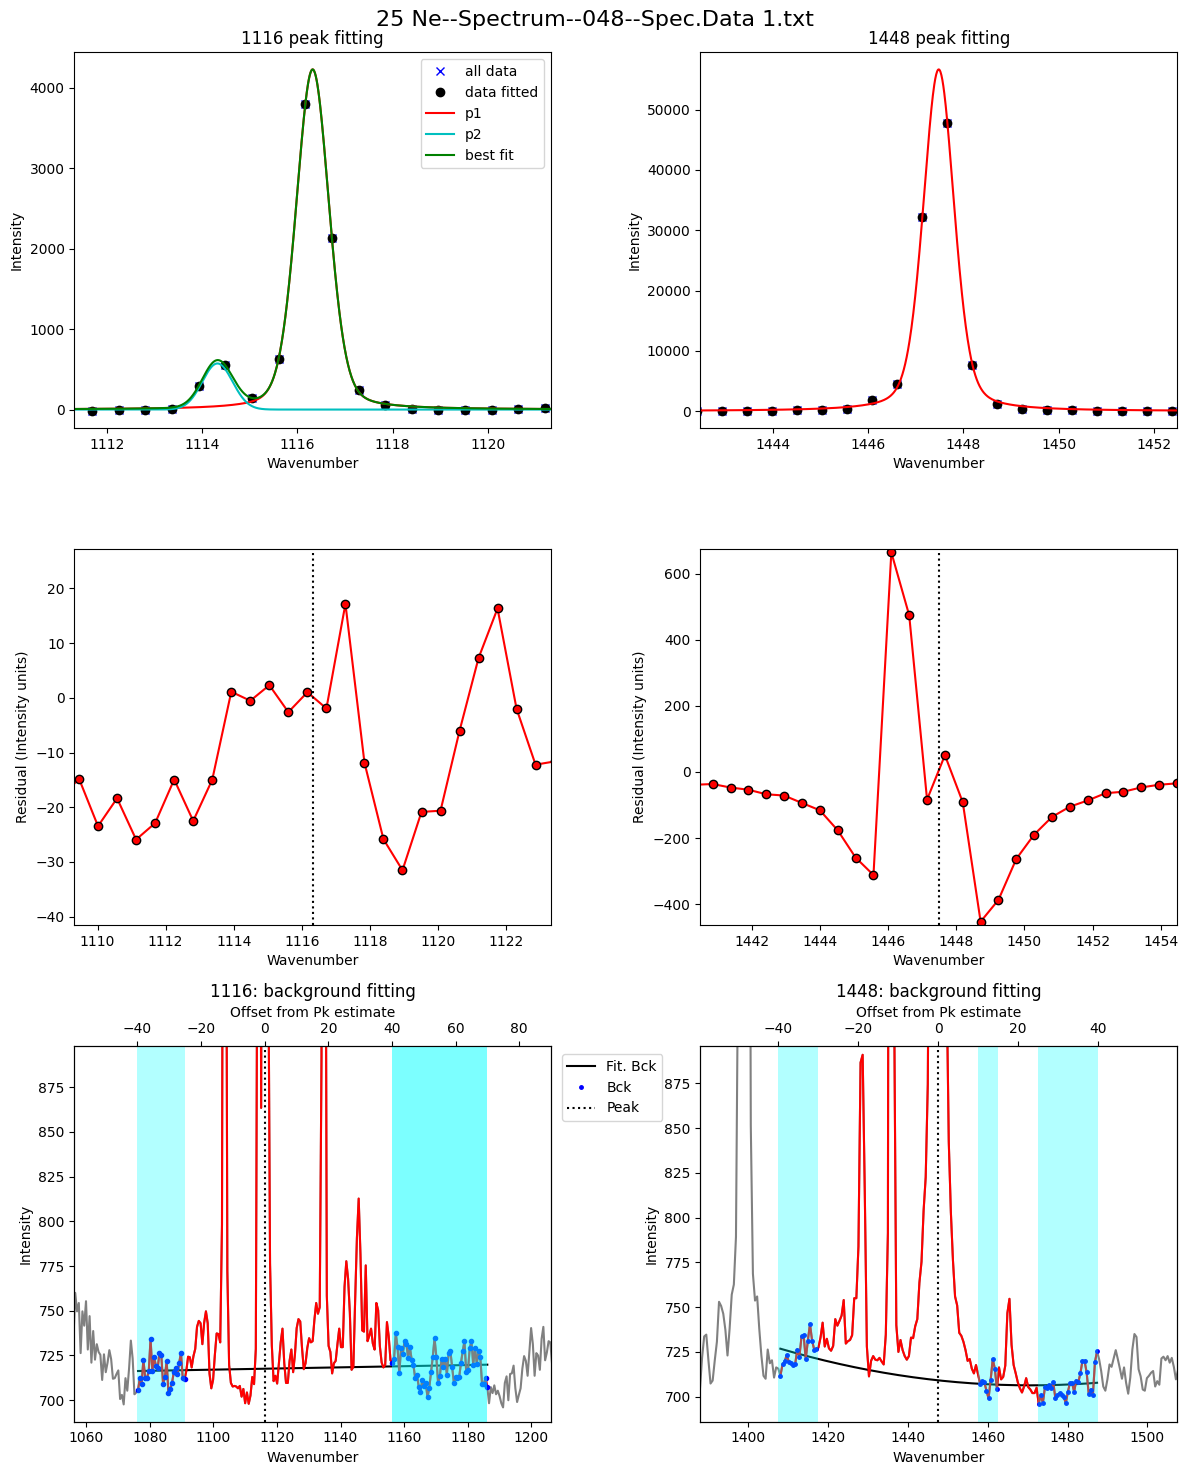

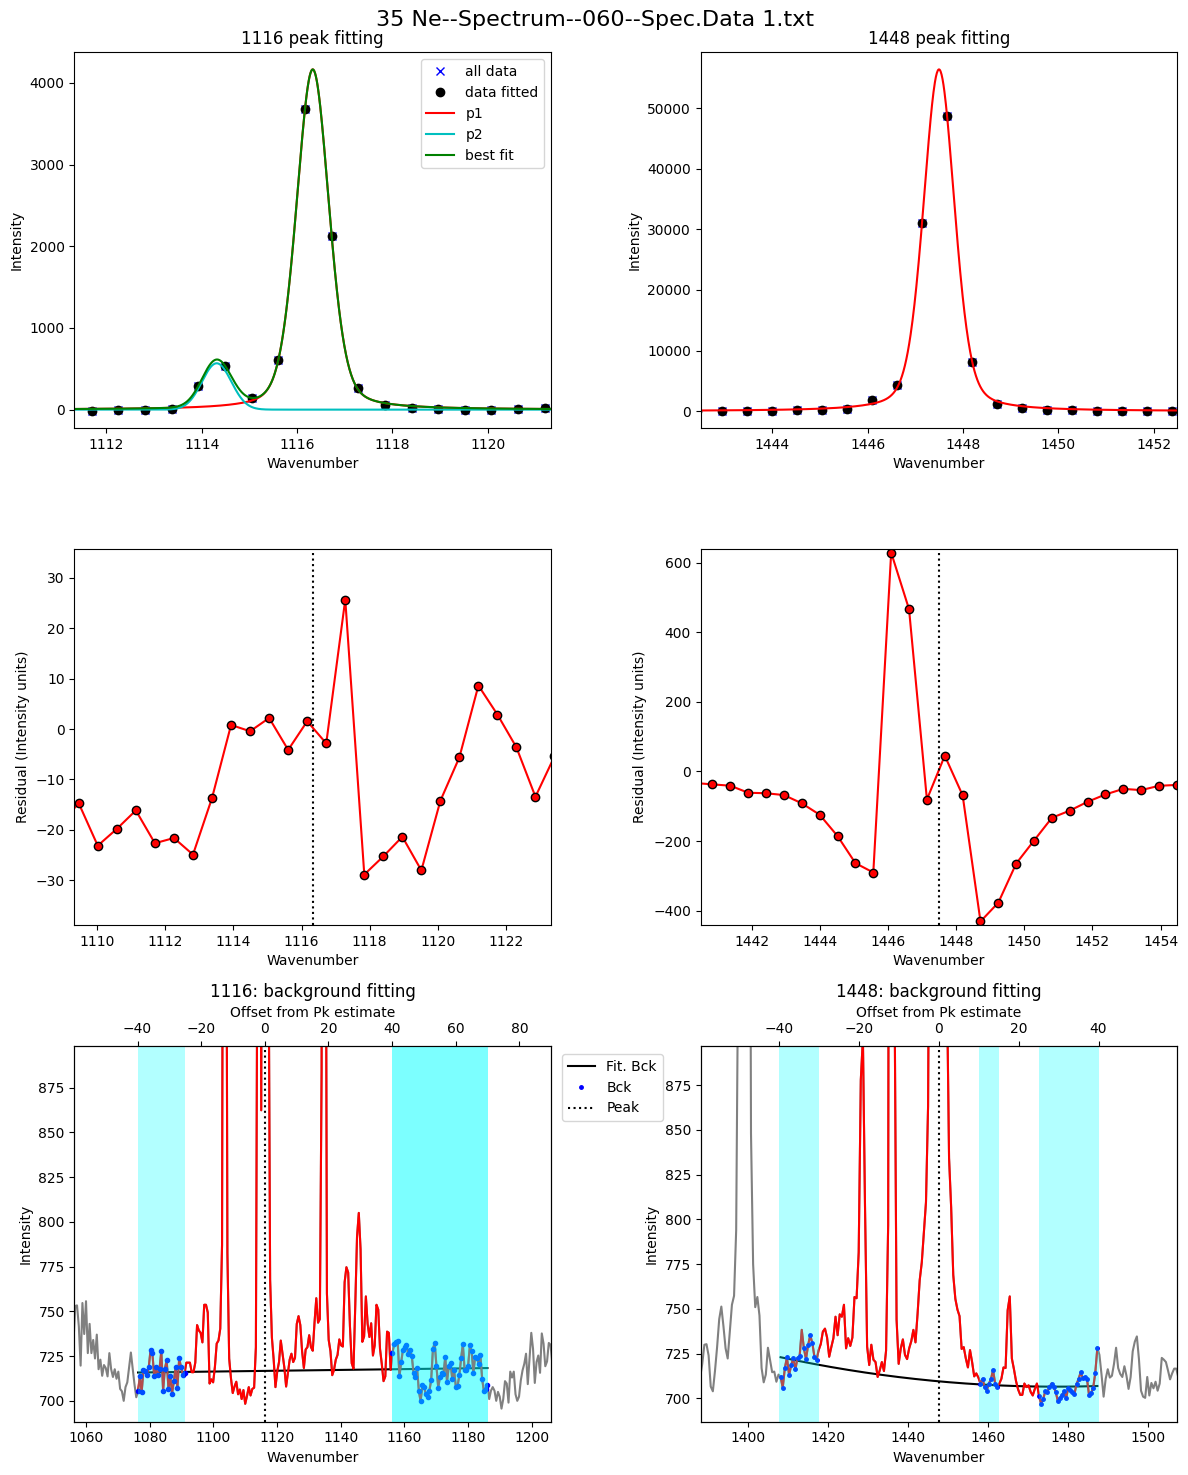

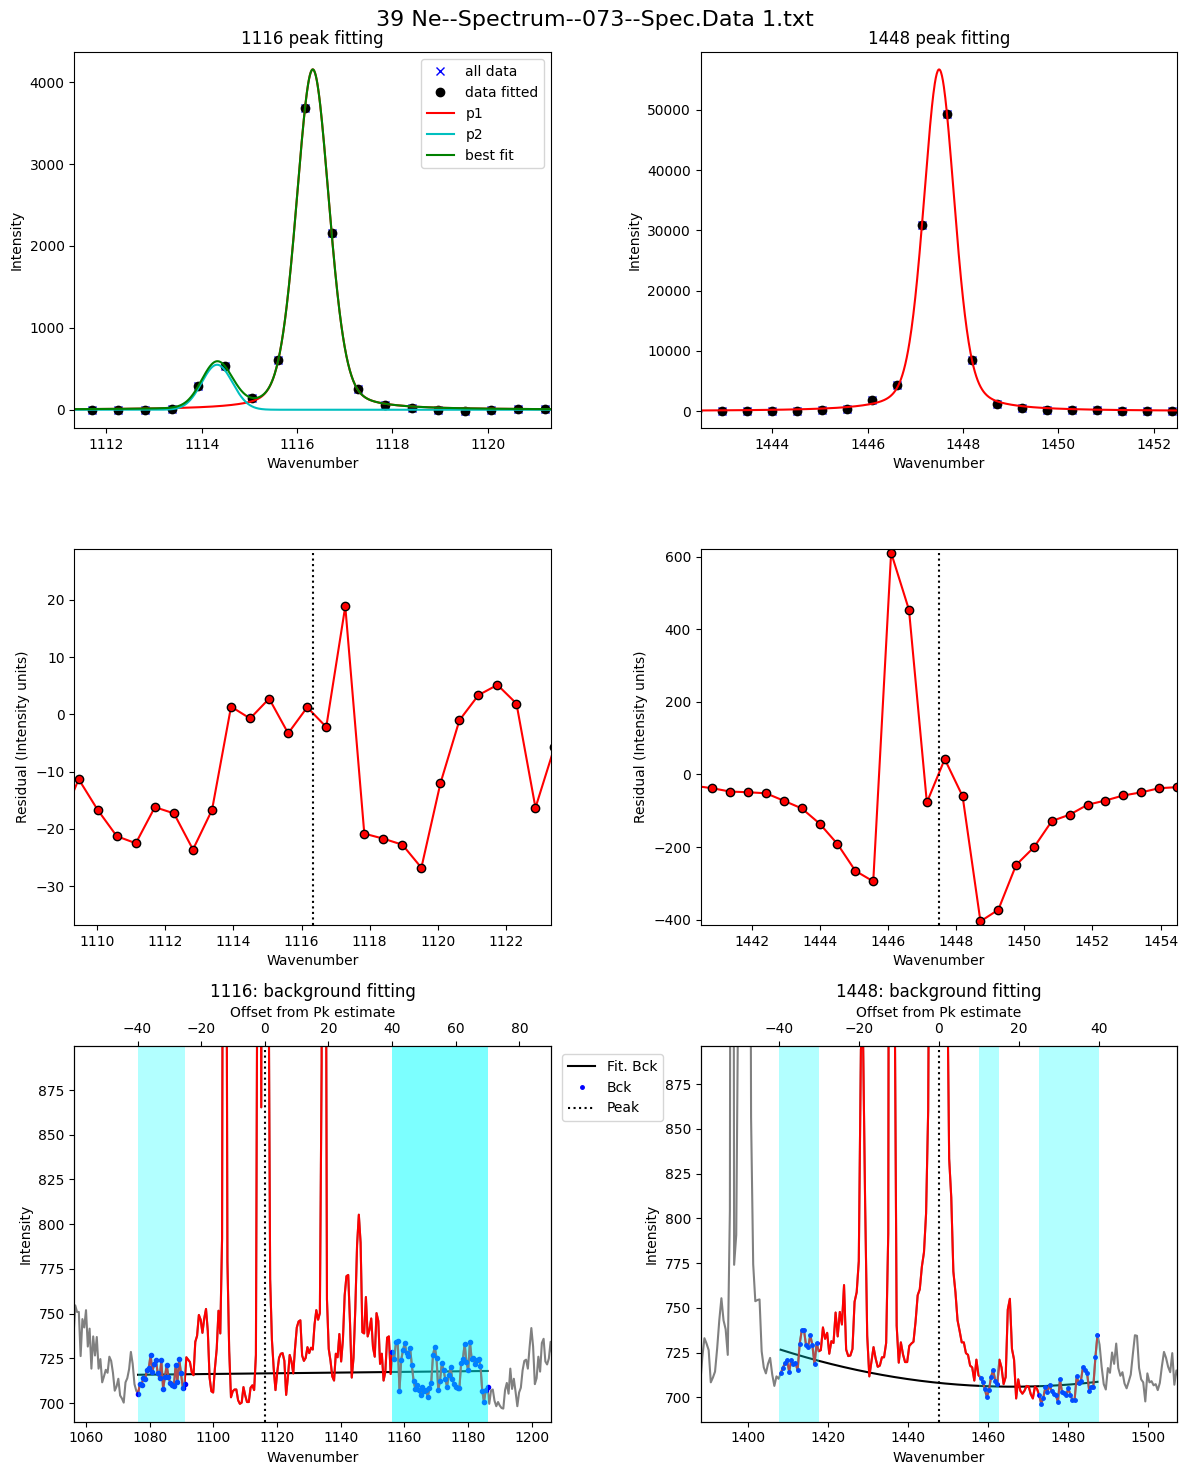

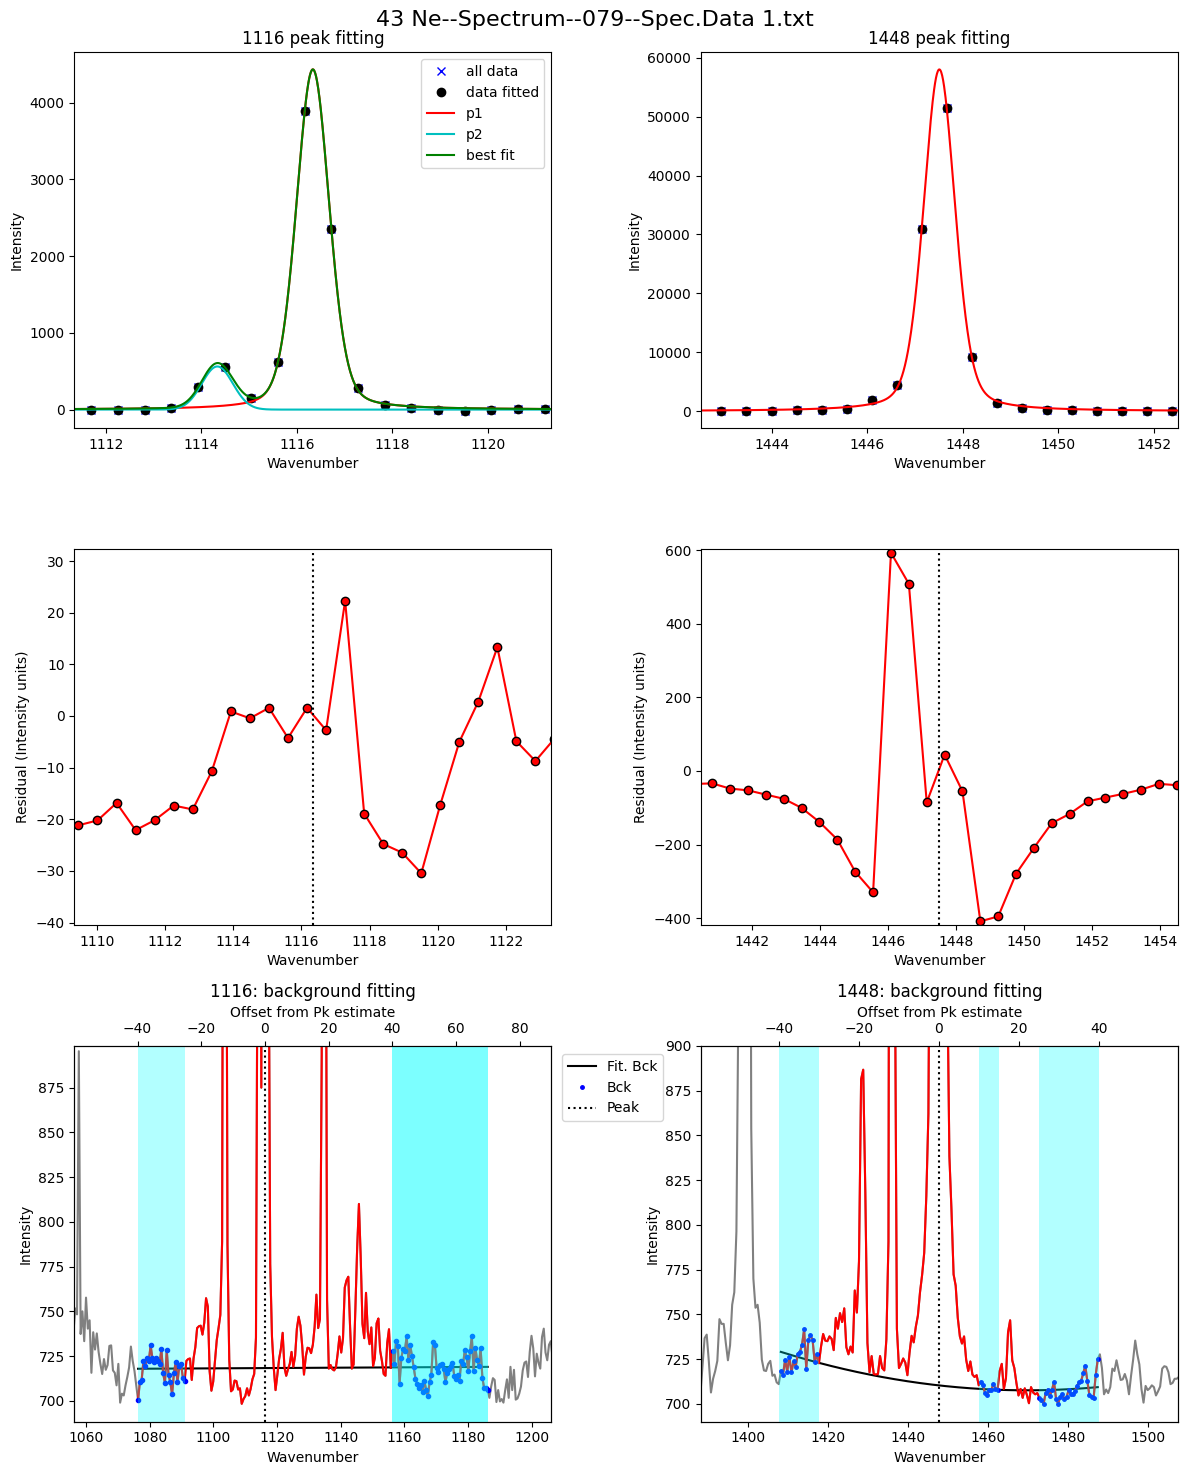

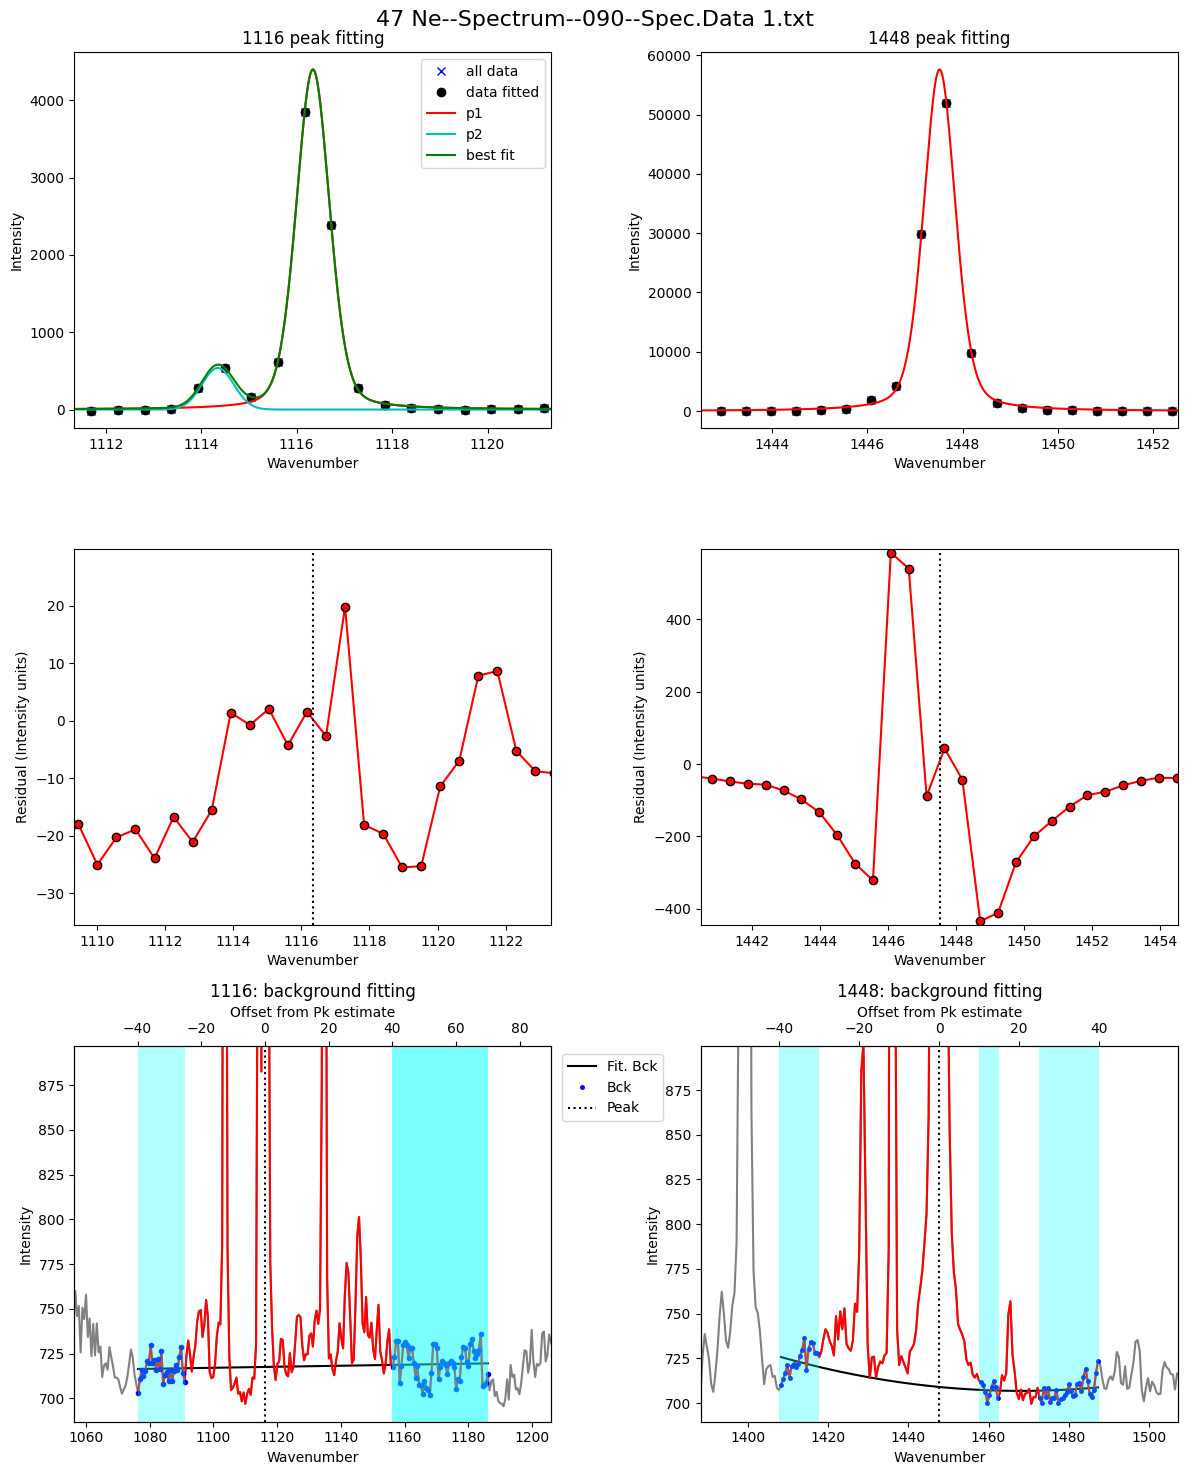

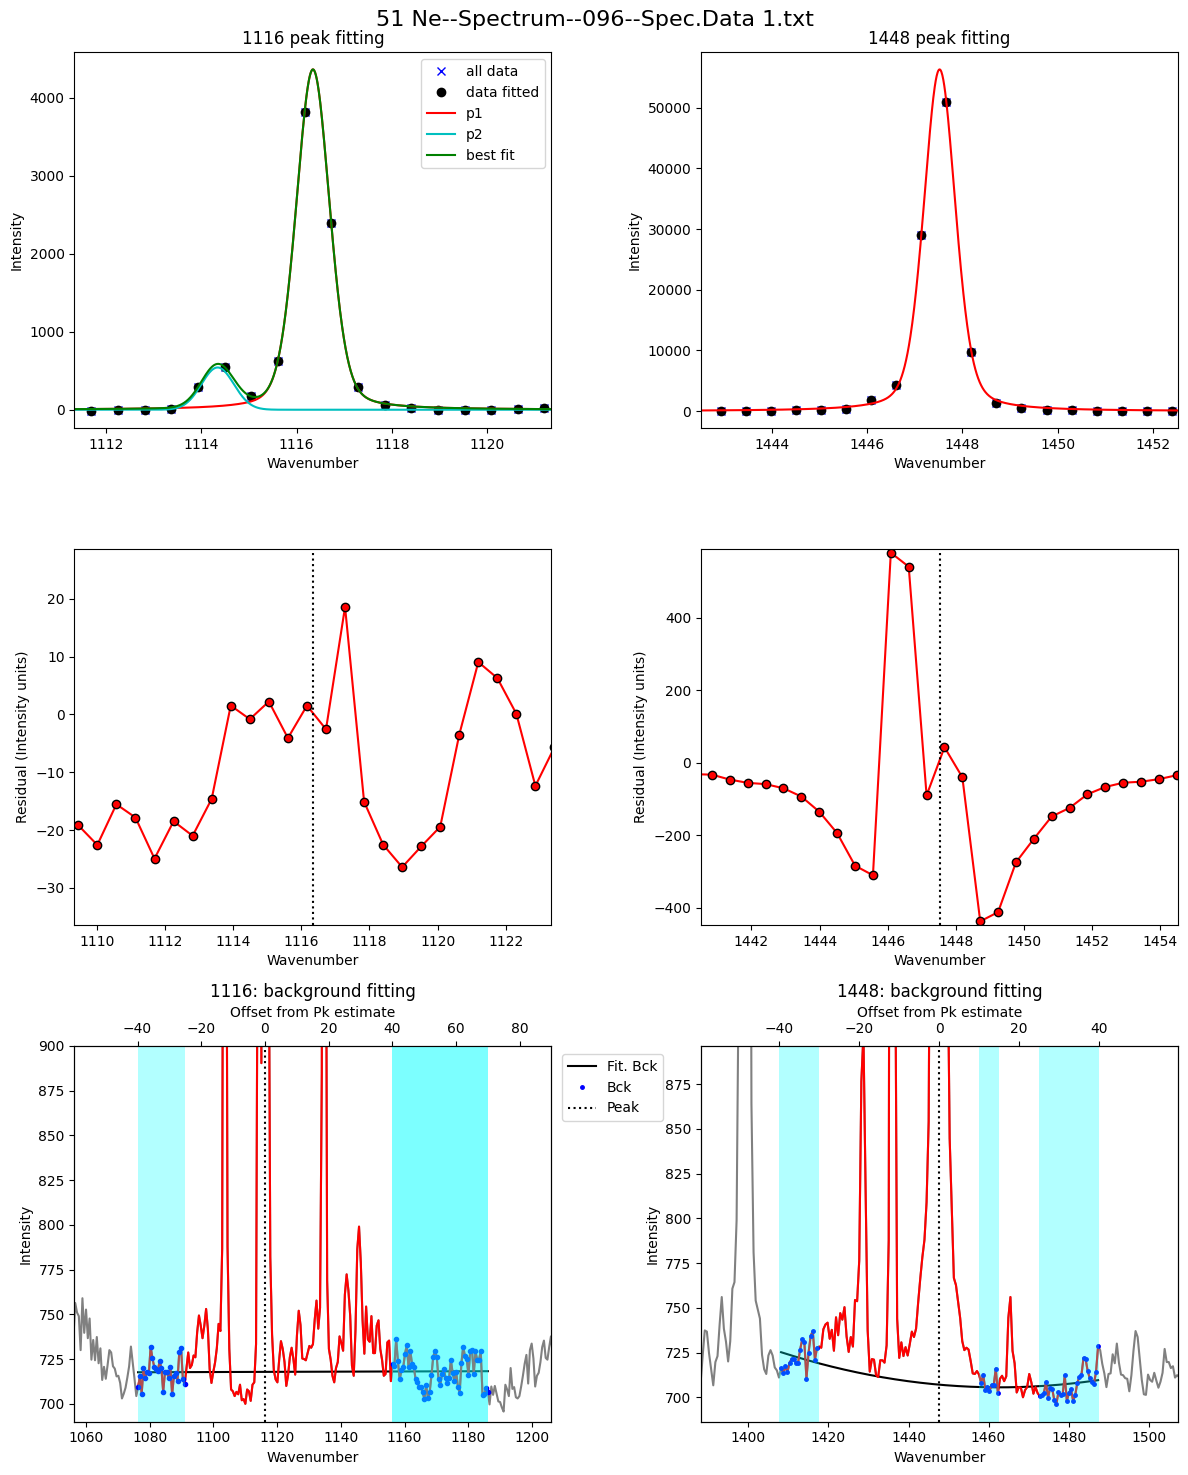

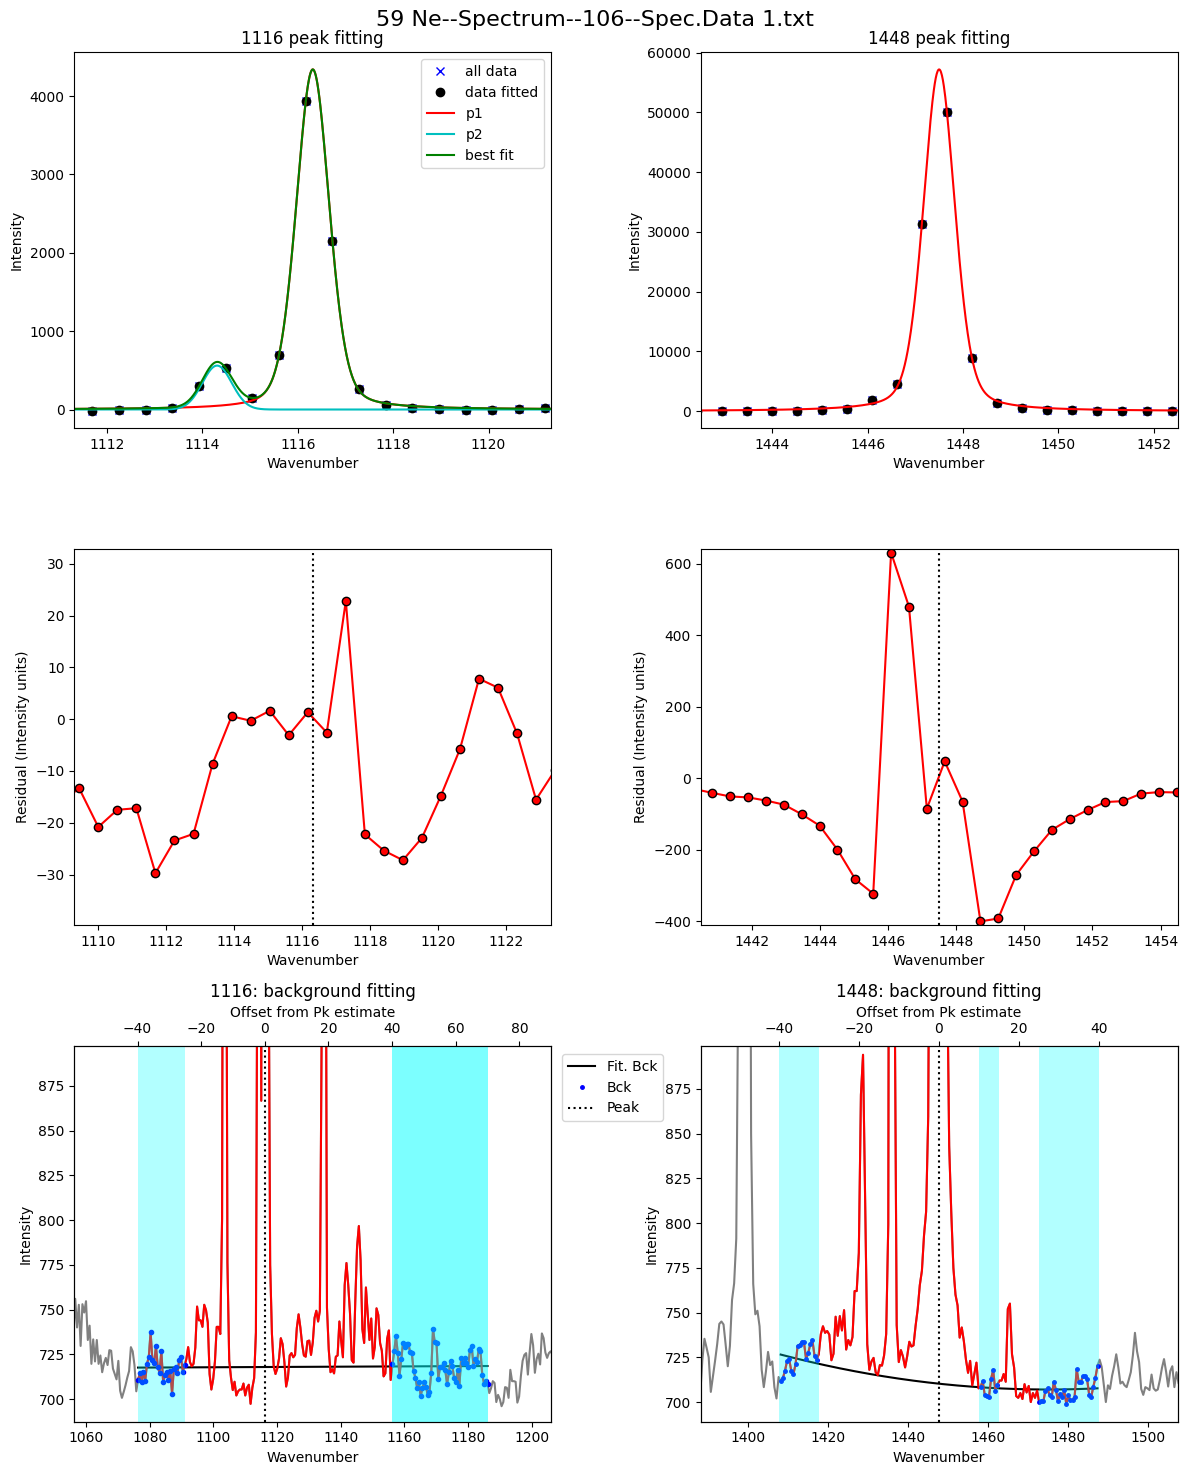

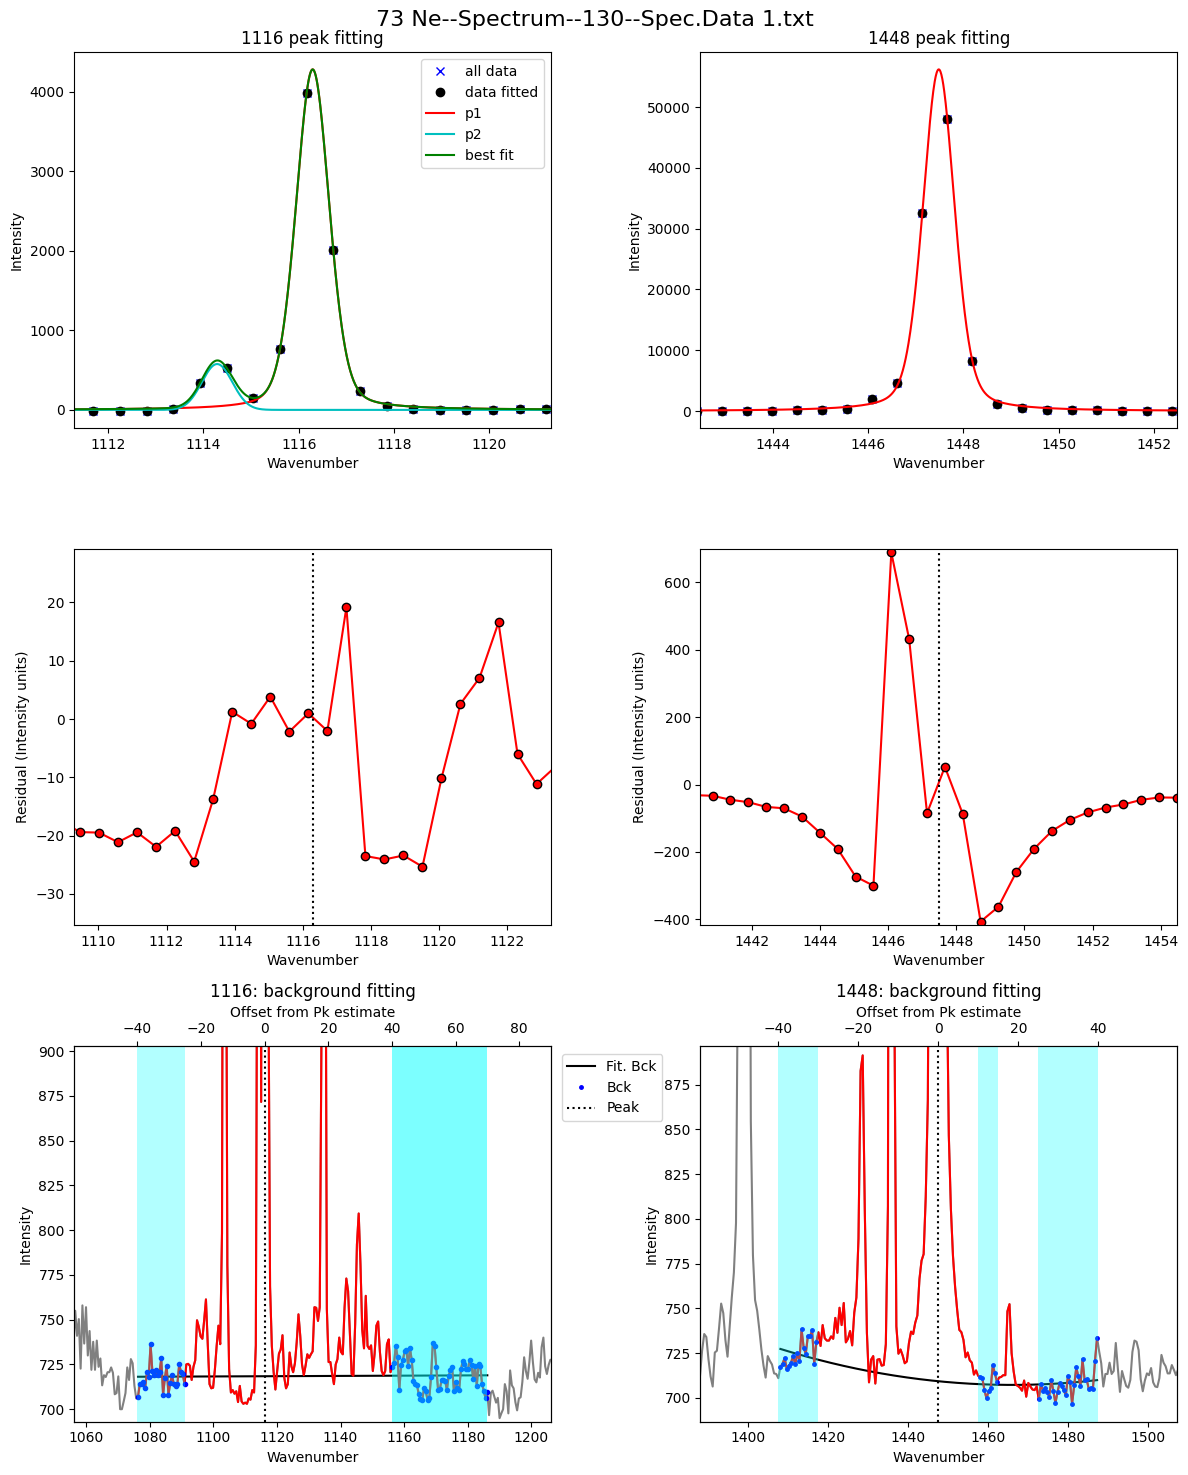

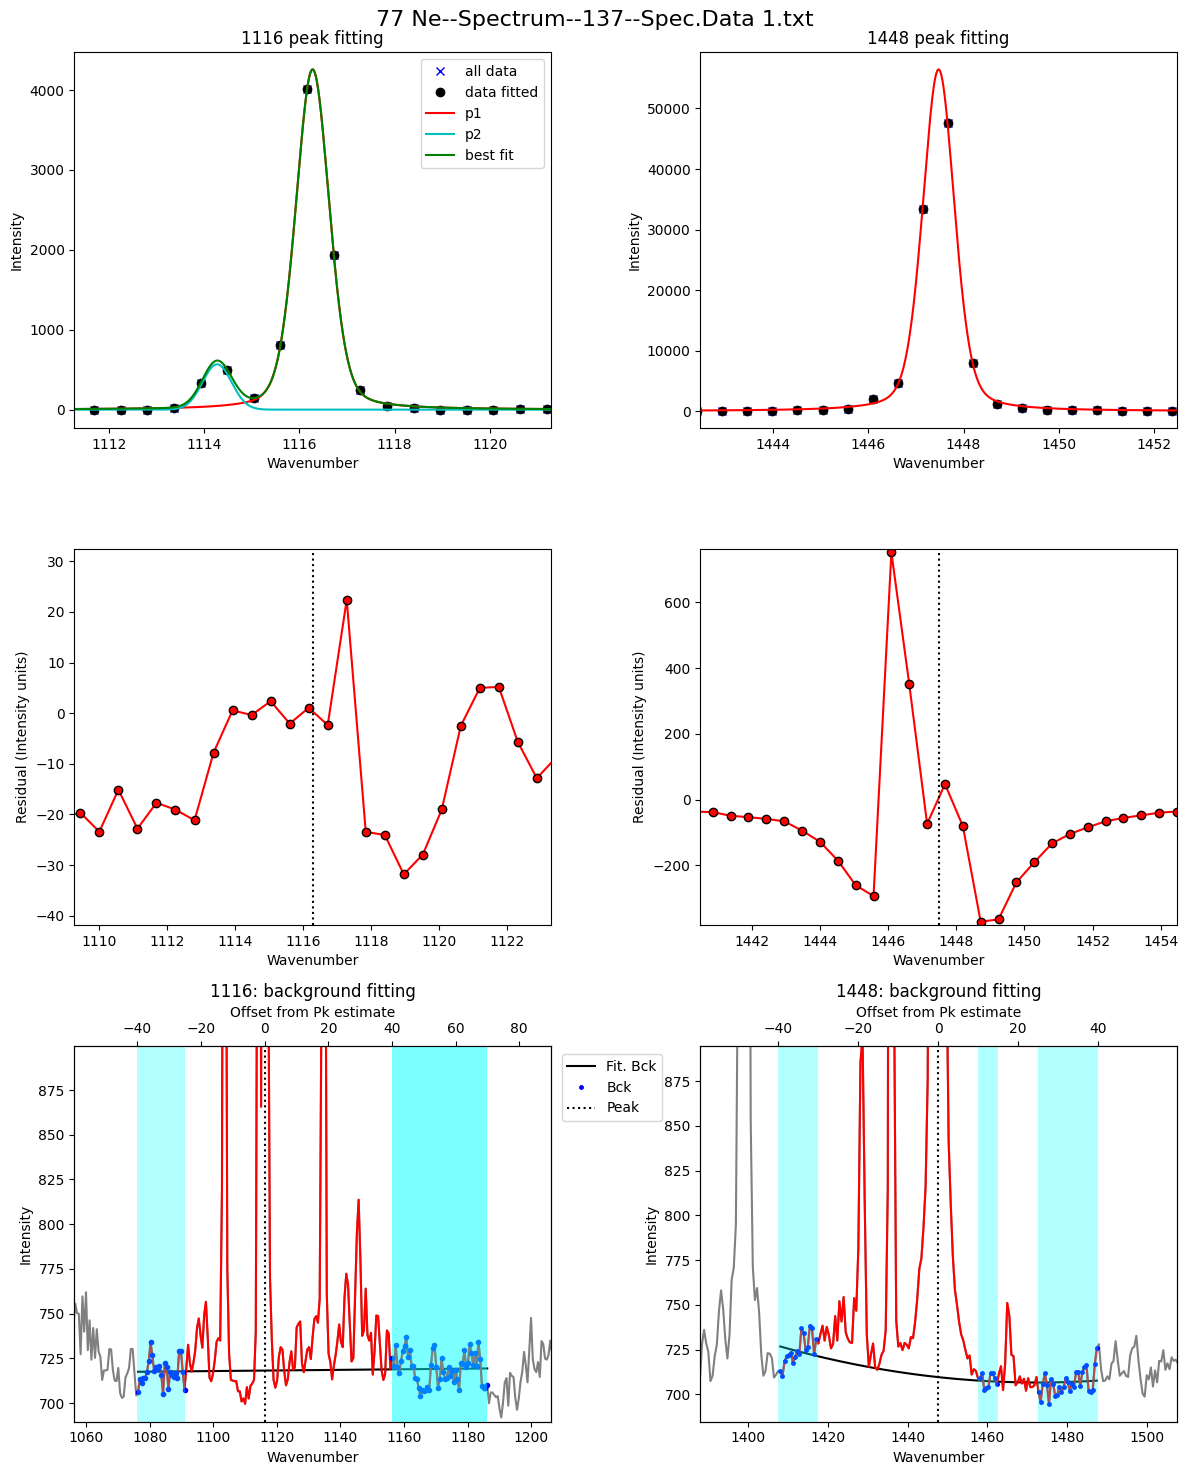

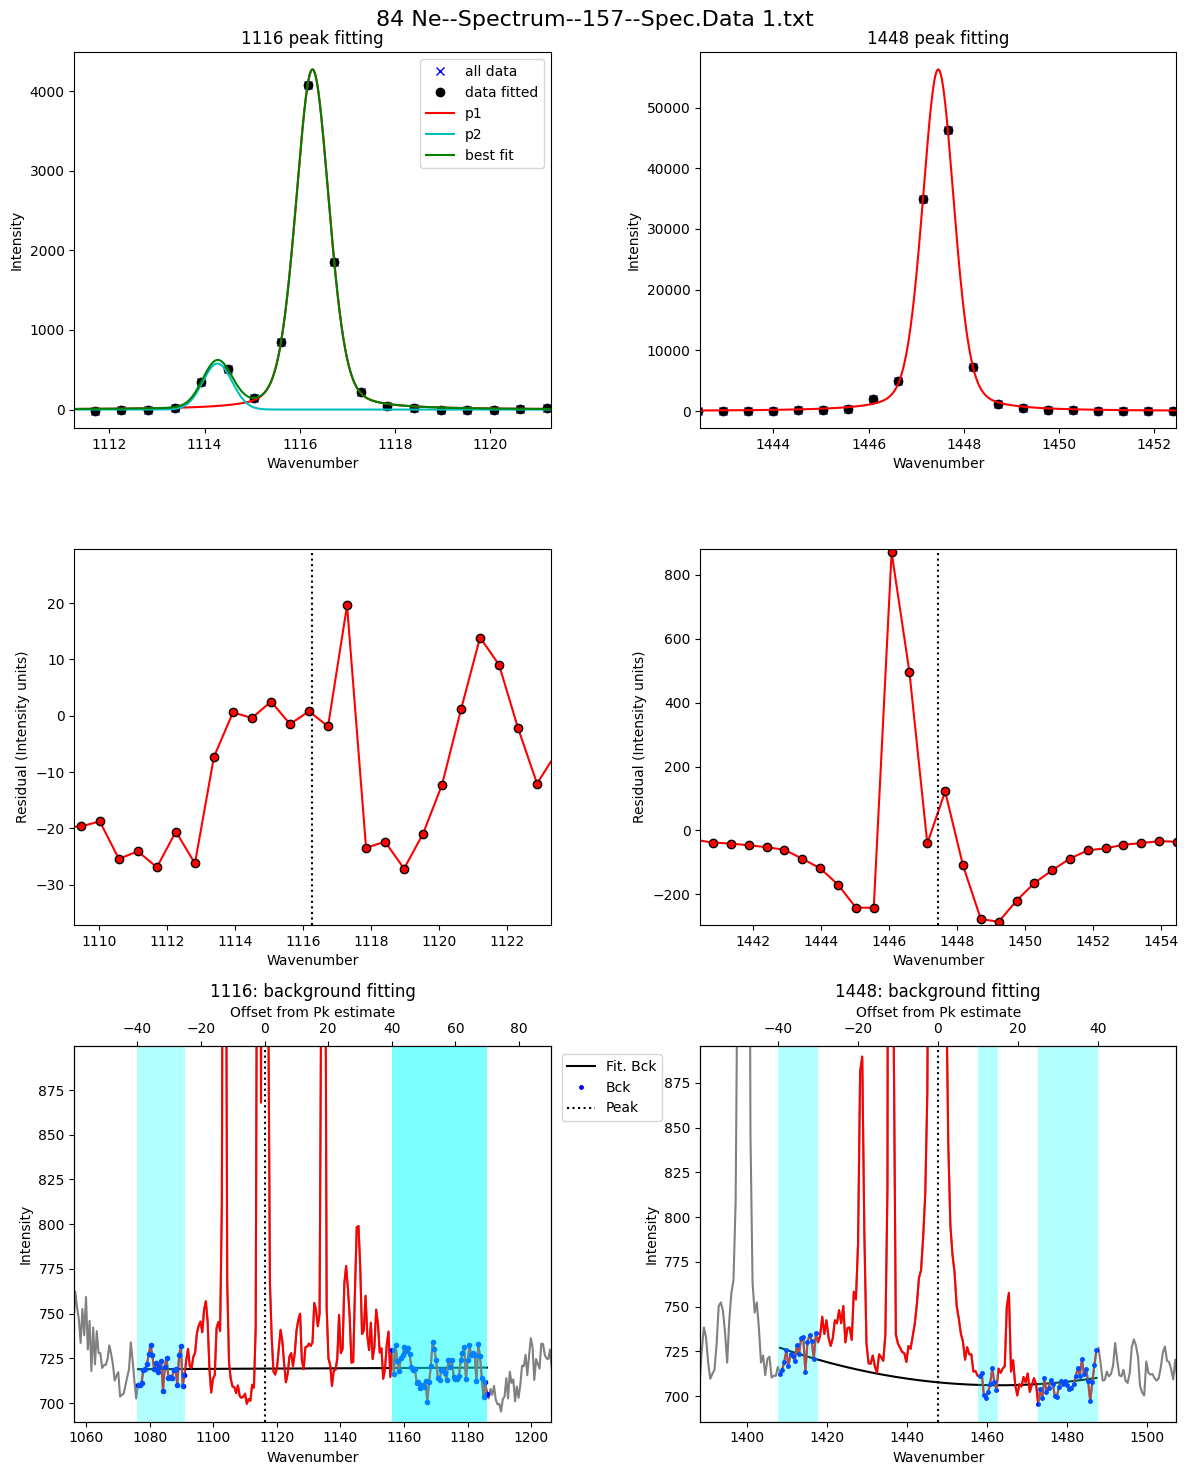

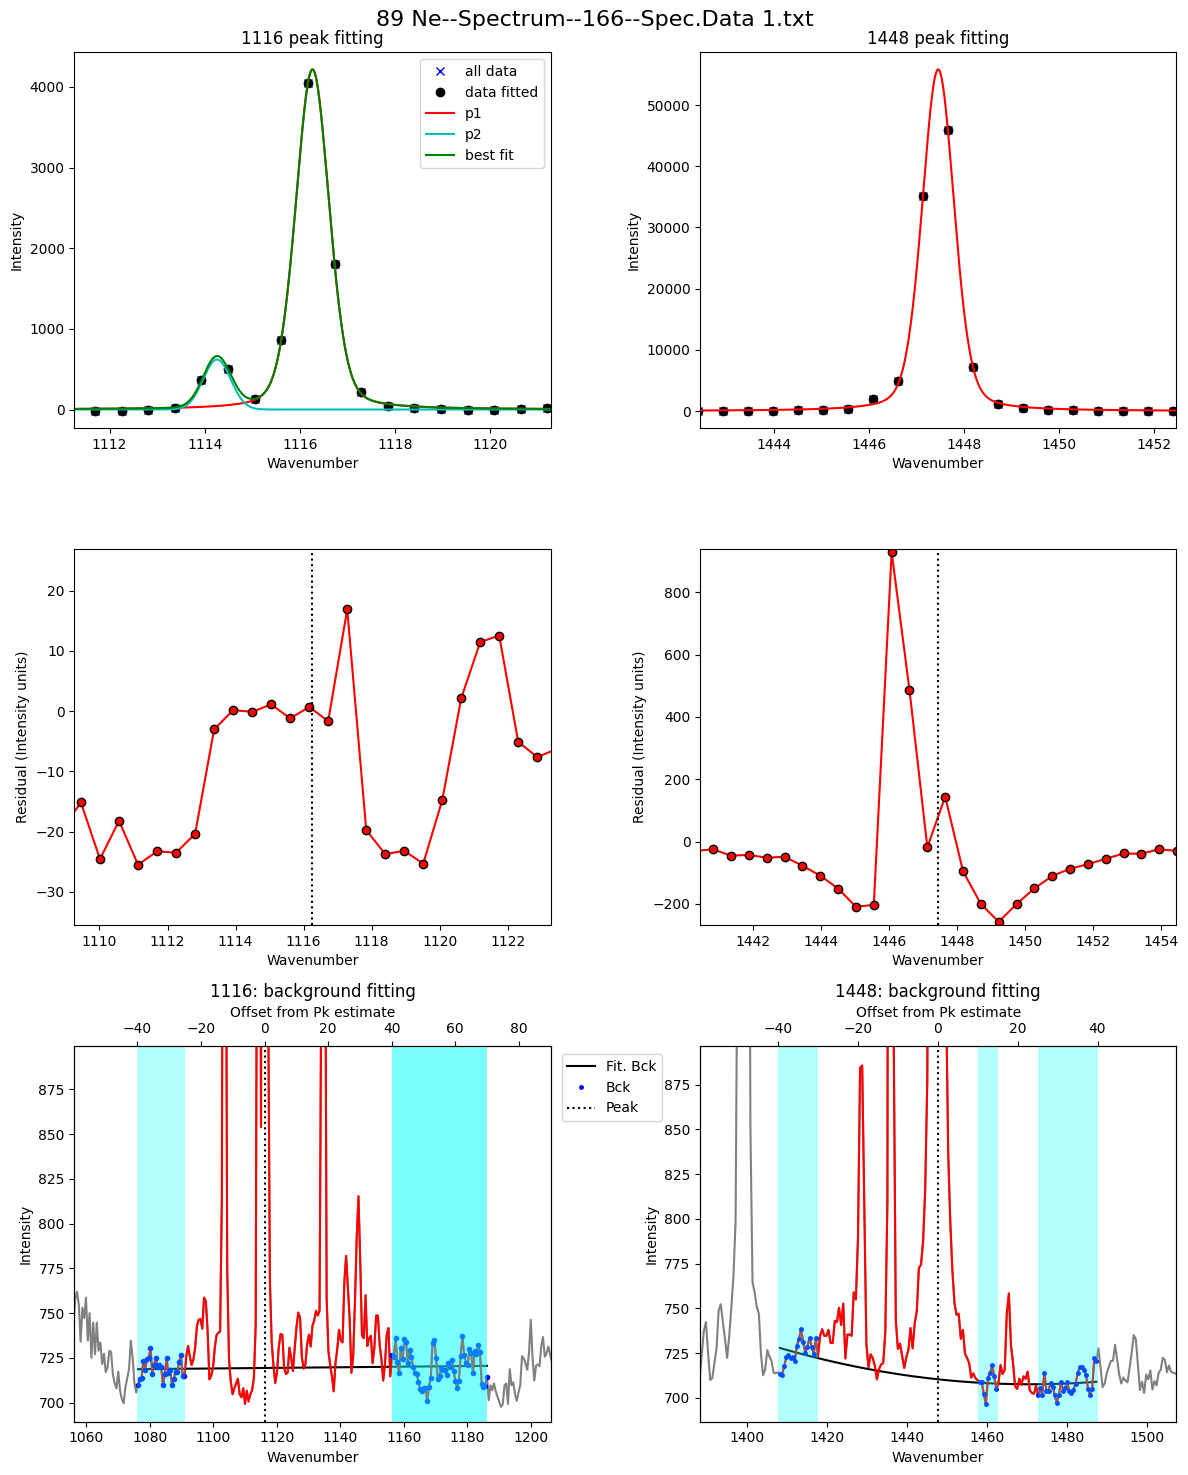

In [19]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [20]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  \
0   Ne--Spectrum--000--Spec.Data 1.txt  0.998030    0.000039  331.129835   
1   Ne--Spectrum--001--Spec.Data 1.txt  0.998039    0.000036  331.126949   
2   Ne--Spectrum--002--Spec.Data 1.txt  0.998030    0.000036  331.130093   
3   Ne--Spectrum--015--Spec.Data 1.txt  0.998028    0.000041  331.130712   
4   Ne--Spectrum--020--Spec.Data 1.txt  0.998014    0.000045  331.135150   
5   Ne--Spectrum--026--Spec.Data 1.txt  0.998009    0.000046  331.136861   
6   Ne--Spectrum--032--Spec.Data 1.txt  0.997977    0.000045  331.147428   
7   Ne--Spectrum--043--Spec.Data 1.txt  0.997964    0.000046  331.151805   
8   Ne--Spectrum--048--Spec.Data 1.txt  0.997937    0.000044  331.160710   
9   Ne--Spectrum--060--Spec.Data 1.txt  0.997925    0.000047  331.164830   
10  Ne--Spectrum--073--Spec.Data 1.txt  0.997914    0.000045  331.168437   
11  Ne--Spectrum--079--Spec.Data 1.txt  0.997903    0.000041  331.172030   
12  Ne--Spectrum--090--Spec.Data 1.txt  0.997885    0.000041  331.178137   
13  Ne--Spectrum--096--Spec.Data 1.txt  0.997884    0.000041  331.178442   
14  Ne--Spectrum--106--Spec.Data 1.txt  0.997862    0.000043  331.185756   
15  Ne--Spectrum--130--Spec.Data 1.txt  0.997848    0.000042  331.190237   
16  Ne--Spectrum--137--Spec.Data 1.txt  0.997834    0.000042  331.195080   
17  Ne--Spectrum--157--Spec.Data 1.txt  0.997842    0.000041  331.192384   
18  Ne--Spectrum--166--Spec.Data 1.txt  0.997833    0.000042  331.195359   

    pk2_peak_cent  pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  \
0     1447.280451    1116.150616   47093.353691    3985.688577    111.150436   
1     1447.309949    1116.182999   50014.269223    4175.784616    118.462813   
2     1447.318131    1116.188038   50674.743258    4198.672405    119.735582   
3     1447.454681    1116.323969   53527.401768    4264.923267    123.592425   
4     1447.472616    1116.337466   52235.582801    4000.561716    120.394836   
5     1447.469875    1116.333015   51716.100386    3999.293637    124.913926   
6     1447.469628    1116.322199   52119.651642    4020.910623    123.554444   
7     1447.472394    1116.320589   52995.369520    4055.037177    121.327015   
8     1447.481126    1116.320415   53103.529734    4094.671664    121.850764   
9     1447.493450    1116.328620   53119.905208    4068.694362    119.253734   
10    1447.497820    1116.329383   53427.712058    4053.091354    117.161047   
11    1447.508235    1116.336205   55066.610322    4313.539537    123.426728   
12    1447.518966    1116.340829   55069.274682    4305.026065    124.653782   
13    1447.520055    1116.341613   54050.984094    4308.531909    123.057797   
14    1447.499153    1116.313397   54528.969828    4276.406749    123.701976   
15    1447.482884    1116.292648   53820.045644    4226.644111    120.630599   
16    1447.476221    1116.281141   53966.576758    4235.268016    117.335750   
17    1447.460285    1116.267902   53331.535217    4221.180994    112.764459   
18    1447.457498    1116.262139   52896.363196    4174.295994    106.748040   

    residual_pk1  ...  pk2_gamma  error_pk2 Peak2_Prop_Lor  pk1_sigma  \
0       9.290030  ...       None    0.00321       0.376861   0.403482   
1      10.510735  ...       None    0.00314       0.365701   0.404653   
2      10.985893  ...       None    0.00310       0.359160   0.403412   
3      12.374127  ...       None    0.00216       0.400692   0.400591   
4      11.727478  ...       None    0.00225       0.407267   0.403560   
5      13.104106  ...       None    0.00238       0.413805   0.397021   
6      12.077112  ...       None    0.00232       0.409937   0.406653   
7      12.126213  ...       None    0.00219       0.397127   0.402581   
8      13.073825  ...       None    0.00222       0.399303   0.406561   
9      13.159511  ...       None    0.00218       0.393898   0.403551   
10     12.470449  ...       None    0.00213       0.393159   0.407491   
11     12.768378  ...       None

## Now extract metadata to get a timestamp for each file

In [21]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['001 Ne--Spectrum--000--Information.txt',
 '002 Ne--Spectrum--001--Information.txt',
 '003 Ne--Spectrum--002--Information.txt',
 '016 Ne--Spectrum--015--Information.txt',
 '021 Ne--Spectrum--020--Information.txt']

In [22]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 19/19 [00:00<00:00, 26.71it/s]

Done


filename                date    Month   Day  \
0  Ne--Spectrum--000--Information.txt  January 11, 2024\n  January  11.0   
1  Ne--Spectrum--001--Information.txt  January 11, 2024\n  January  11.0   
2  Ne--Spectrum--002--Information.txt  January 11, 2024\n  January  11.0   
3  Ne--Spectrum--015--Information.txt  January 11, 2024\n  January  11.0   
4  Ne--Spectrum--020--Information.txt  January 11, 2024\n  January  11.0   

   power (mW)  Int_time (s)  accumulations  Mag (X)             duration  \
0       5.830          45.0            3.0     50.0  ['0h', '2m', '16s']   
1       5.814          45.0            3.0     50.0  ['0h', '2m', '16s']   
2       5.777          45.0            3.0     50.0  ['0h', '2m', '16s']   
3       6.071          45.0            3.0    100.0  ['0h', '2m', '17s']   
4       6.000          45.0            3.0    100.0  ['0h', '2m', '17s']   

       24hr_time  sec since midnight  Spectral Center  
0  10:50:03 AM\n             39003.0         1325.004  
1  10:58:14 AM\n             39494.0         1325.004  
2  11:00:33 AM\n             39633.0         1325.004  
3  11:49:26 AM\n             42566.0         1325.004  
4  12:05:48 PM\n             43548.0         1325.004

In [23]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext='.txt')
file_m

good job, no duplicate file names


array(['Ne--Spectrum--000--Information', 'Ne--Spectrum--001--Information',
       'Ne--Spectrum--002--Information', 'Ne--Spectrum--015--Information',
       'Ne--Spectrum--020--Information', 'Ne--Spectrum--026--Information',
       'Ne--Spectrum--032--Information', 'Ne--Spectrum--043--Information',
       'Ne--Spectrum--048--Information', 'Ne--Spectrum--060--Information',
       'Ne--Spectrum--073--Information', 'Ne--Spectrum--079--Information',
       'Ne--Spectrum--090--Information', 'Ne--Spectrum--096--Information',
       'Ne--Spectrum--106--Information', 'Ne--Spectrum--130--Information',
       'Ne--Spectrum--137--Information', 'Ne--Spectrum--157--Information',
       'Ne--Spectrum--166--Information'], dtype=object)

In [24]:
for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m

array(['Ne--Spectrum--000', 'Ne--Spectrum--001', 'Ne--Spectrum--002',
       'Ne--Spectrum--015', 'Ne--Spectrum--020', 'Ne--Spectrum--026',
       'Ne--Spectrum--032', 'Ne--Spectrum--043', 'Ne--Spectrum--048',
       'Ne--Spectrum--060', 'Ne--Spectrum--073', 'Ne--Spectrum--079',
       'Ne--Spectrum--090', 'Ne--Spectrum--096', 'Ne--Spectrum--106',
       'Ne--Spectrum--130', 'Ne--Spectrum--137', 'Ne--Spectrum--157',
       'Ne--Spectrum--166'], dtype=object)

In [25]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext='.txt')
file_s

good job, no duplicate file names


array(['Ne--Spectrum--000--Spec.Data 1', 'Ne--Spectrum--001--Spec.Data 1',
       'Ne--Spectrum--002--Spec.Data 1', 'Ne--Spectrum--015--Spec.Data 1',
       'Ne--Spectrum--020--Spec.Data 1', 'Ne--Spectrum--026--Spec.Data 1',
       'Ne--Spectrum--032--Spec.Data 1', 'Ne--Spectrum--043--Spec.Data 1',
       'Ne--Spectrum--048--Spec.Data 1', 'Ne--Spectrum--060--Spec.Data 1',
       'Ne--Spectrum--073--Spec.Data 1', 'Ne--Spectrum--079--Spec.Data 1',
       'Ne--Spectrum--090--Spec.Data 1', 'Ne--Spectrum--096--Spec.Data 1',
       'Ne--Spectrum--106--Spec.Data 1', 'Ne--Spectrum--130--Spec.Data 1',
       'Ne--Spectrum--137--Spec.Data 1', 'Ne--Spectrum--157--Spec.Data 1',
       'Ne--Spectrum--166--Spec.Data 1'], dtype=object)

In [26]:
for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

array(['Ne--Spectrum--000', 'Ne--Spectrum--001', 'Ne--Spectrum--002',
       'Ne--Spectrum--015', 'Ne--Spectrum--020', 'Ne--Spectrum--026',
       'Ne--Spectrum--032', 'Ne--Spectrum--043', 'Ne--Spectrum--048',
       'Ne--Spectrum--060', 'Ne--Spectrum--073', 'Ne--Spectrum--079',
       'Ne--Spectrum--090', 'Ne--Spectrum--096', 'Ne--Spectrum--106',
       'Ne--Spectrum--130', 'Ne--Spectrum--137', 'Ne--Spectrum--157',
       'Ne--Spectrum--166'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [27]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [28]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

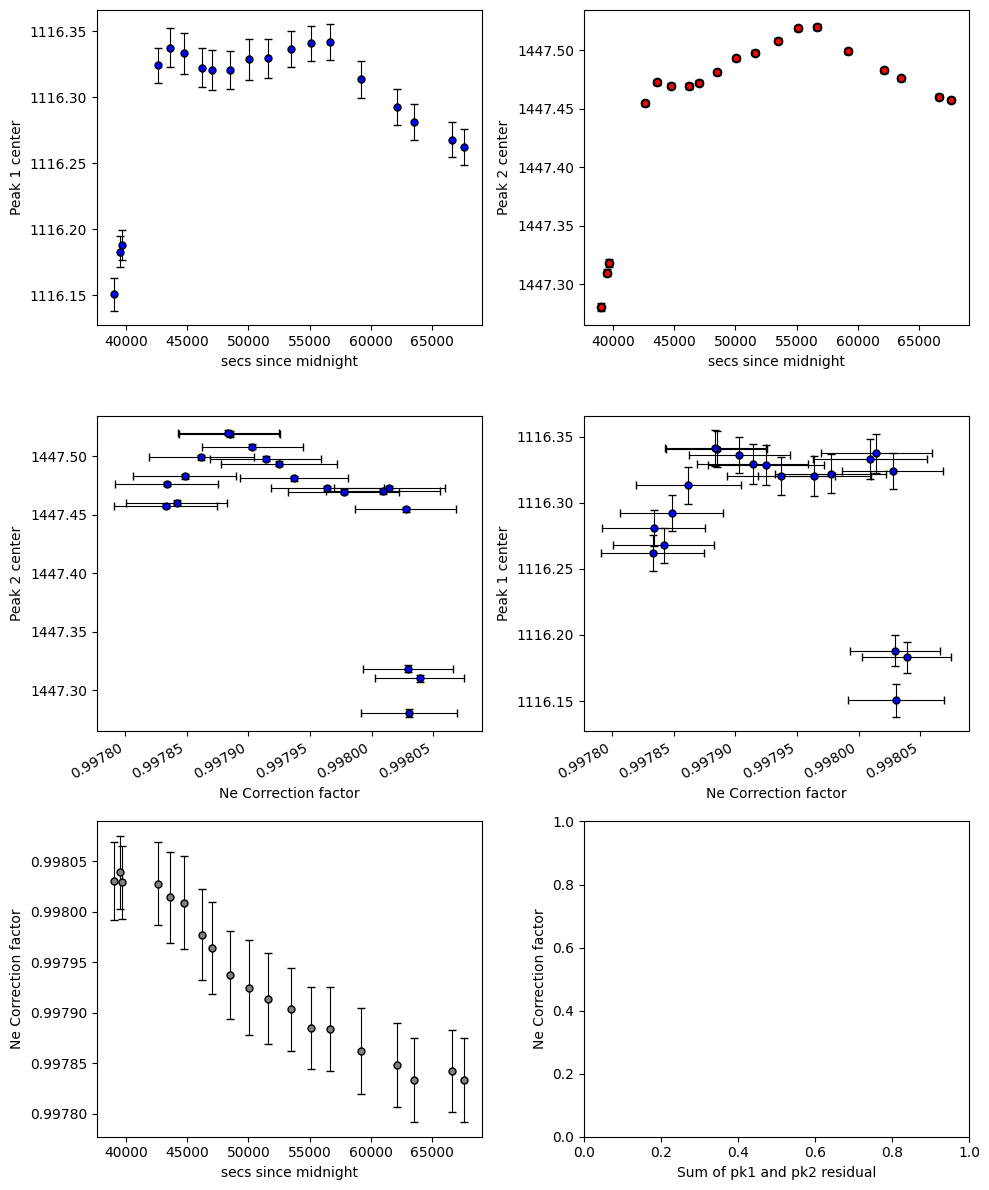

In [29]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

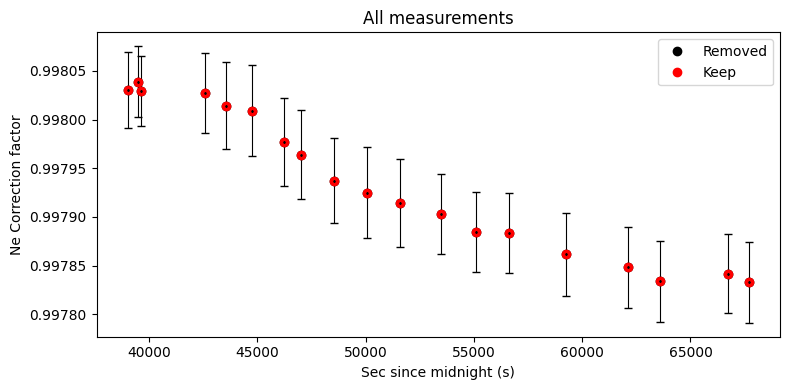

In [30]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

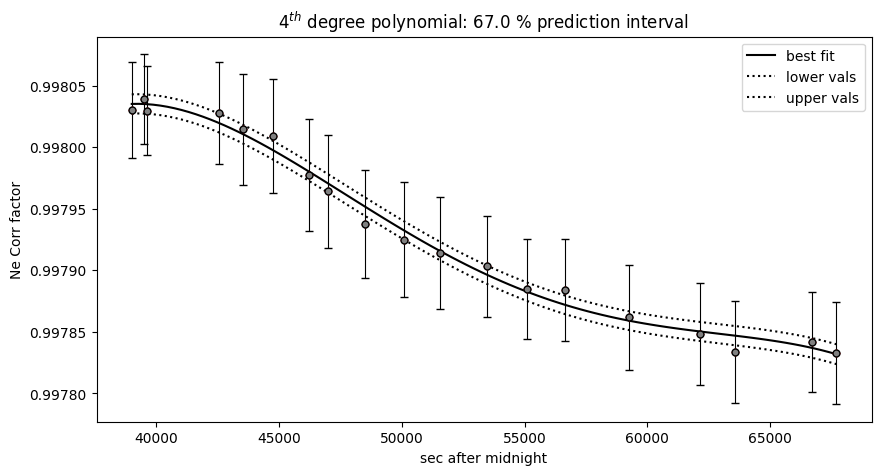

In [31]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=4, CI=0.67, pkl_name='Neon_corr_model.pkl')
